# 1. Imports

In [2]:
import locale

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
import seaborn as sns

from datetime import datetime

from math import floor



# 2. Settings

In [3]:
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')
plt.style.use('ggplot')
RANDOM_SEED = 0

# 3. Loading Data

In [4]:
def read_transport_data(filename):
    types_mapping = {
        'Numer / oznaczenie linii' : str,                                     
        'Wariant linii' : str,                                              
        'Kurs' : str,                                                        
        'Oznaczenie brygady' : str,
        'Czas rzeczywisty odjazdu wg. rozkładu' : str,                              
        'Czas odjazdu z przystanku' : str,
    }

    df = pd.read_csv(filename, sep=';', dtype=types_mapping)
    df = df.drop(columns='Data')
    
    names_mapping = {
        'Numer / oznaczenie linii' : 'Nr linii',                                     
        # 'Wariant linii'                                                    
        # 'Kurs'                                                                
        # 'Oznaczenie brygady'                                                  
        # 'Numer taborowy'                                                     
        # 'Nazwa przystanku'                                                    
        # 'Numer przystanku'                                                   
        'Czas rzeczywisty odjazdu wg. rozkładu' : 'Rzeczywisty czas odjazdu',                              
        'Czas odjazdu z przystanku' : 'Rozkładowy czas odjazdu',                                      
        'Liczba pasażerów w pojeździe przed przystankiem (dane skorygowane)' : 'Liczba pasaz. przed',  
        'Liczba osób które wysiadły (dane skorygowane)' : 'Liczba wysiadających pasaz.',                       
        'Liczba osób które wsiadły (dane skorygowane)' : 'Liczba wsiadajacych pasaz.',                     
        'Liczba pasażerów w pojeździe po odjeździe (dane skorygowane)' : 'Liczba pasaz. po odjezdzie'
    }
    df.rename(columns=names_mapping, inplace=True)

    

    return df

In [5]:
df = read_transport_data('./data/SZP-2021-09-03.csv')

# 4. Inspecting Data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177546 entries, 0 to 177545
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Nr linii                     177546 non-null  object
 1   Wariant linii                177546 non-null  object
 2   Kurs                         177546 non-null  object
 3   Oznaczenie brygady           177546 non-null  object
 4   Numer taborowy               177546 non-null  int64 
 5   Nazwa przystanku             177546 non-null  object
 6   Numer przystanku             177546 non-null  int64 
 7   Rzeczywisty czas odjazdu     172273 non-null  object
 8   Rozkładowy czas odjazdu      177546 non-null  object
 9   Liczba pasaz. przed          177546 non-null  int64 
 10  Liczba wysiadających pasaz.  177546 non-null  int64 
 11  Liczba wsiadajacych pasaz.   177546 non-null  int64 
 12  Liczba pasaz. po odjezdzie   177546 non-null  int64 
dtypes: int64(6), o

In [7]:
df.sample(5)

Nr linii Wariant linii   Kurs Oznaczenie brygady  Numer taborowy  \
161018      739        TO-JUC  16:13                  6            9302   
110690      212        TP-CHT  21:45                  3            9677   
10422       118        TP-MPL  18:20                  4            9676   
11181       118        TP-BRP  07:48                  6            9679   
104746      211        TP-FSO  04:46                  3            9242   

        Nazwa przystanku  Numer przystanku Rzeczywisty czas odjazdu  \
161018           Wyścigi                 1                 16:19:00   
110690       Namysłowska                 2                 21:49:00   
10422   pl.Trzech Krzyży                 3                 18:55:00   
11181   pl.Trzech Krzyży                 4                 07:55:00   
104746           Porajów                 4                 05:06:00   

       Rozkładowy czas odjazdu  Liczba pasaz. przed  \
161018                   16:23                   71   
110690                21:47:47                    2   
10422                 18:55:07                   11   
11181                 07:55:21                   16   
104746                   05:05                    7   

        Liczba wysiadających pasaz.  Liczba wsiadajacych pasaz.  \
161018                            1                           1   
110690                            0                           0   
10422                             4                           0   
11181                             2                           3   
104746                            0                           2   

        Liczba pasaz. po odjezdzie  
161018                          71  
110690                           2  
10422                            7  
11181                           17  
104746                           9

In [8]:
df.describe()

Numer taborowy  Numer przystanku  Liczba pasaz. przed  \
count   177546.000000     177546.000000        177546.000000   
mean      9513.375953          3.437903            12.060711   
std        265.044802          7.857952            12.341741   
min       9061.000000          1.000000            -3.000000   
25%       9319.000000          1.000000             4.000000   
50%       9452.000000          2.000000             9.000000   
75%       9806.000000          3.000000            16.000000   
max       9955.000000         88.000000           133.000000   

       Liczba wysiadających pasaz.  Liczba wsiadajacych pasaz.  \
count                177546.000000               177546.000000   
mean                      1.560435                    1.570534   
std                       3.136487                    3.192504   
min                       0.000000                    0.000000   
25%                       0.000000                    0.000000   
50%                       0.000000                    0.000000   
75%                       2.000000                    2.000000   
max                     124.000000                  110.000000   

       Liczba pasaz. po odjezdzie  
count               177546.000000  
mean                    12.070810  
std                     12.335713  
min                      0.000000  
25%                      4.000000  
50%                      9.000000  
75%                     16.000000  
max                    133.000000

# 4.1. Check data

In [9]:
counter = 0
counter += len(df.loc[df['Liczba pasaz. przed'] - df['Liczba wysiadających pasaz.'] + df['Liczba wsiadajacych pasaz.'] != df['Liczba pasaz. po odjezdzie']])
counter += len(df[df['Liczba pasaz. przed'] < 0])
print(f'Amount of invalid data: {counter}')

Amount of invalid data: 2


# 4.2. Remove errors

In [10]:
df.drop(df[df['Liczba pasaz. przed'] < 0].index, inplace=True) # remove invlid amout of passengers

df.drop(df[df['Kurs'].str[:2] > '23'].index, inplace= True)

is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

df.drop(df[row_has_NaN].index, inplace=True)


In [11]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 167342 entries, 0 to 177545
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Nr linii                     167342 non-null  object
 1   Wariant linii                167342 non-null  object
 2   Kurs                         167342 non-null  object
 3   Oznaczenie brygady           167342 non-null  object
 4   Numer taborowy               167342 non-null  int64 
 5   Nazwa przystanku             167342 non-null  object
 6   Numer przystanku             167342 non-null  int64 
 7   Rzeczywisty czas odjazdu     167342 non-null  object
 8   Rozkładowy czas odjazdu      167342 non-null  object
 9   Liczba pasaz. przed          167342 non-null  int64 
 10  Liczba wysiadających pasaz.  167342 non-null  int64 
 11  Liczba wsiadajacych pasaz.   167342 non-null  int64 
 12  Liczba pasaz. po odjezdzie   167342 non-null  int64 
dtypes: int64(6), o

# 4.3. Parse data

In [13]:
def make_date_one_type(x):
    return pd.Timestamp(x)

In [14]:
df['Kurs'] = df['Kurs'].apply(lambda x: make_date_one_type(x))
df['Rzeczywisty czas odjazdu'] = df['Rzeczywisty czas odjazdu'].apply(lambda x: make_date_one_type(x))
df['Rozkładowy czas odjazdu'] = df['Rozkładowy czas odjazdu'].apply(lambda x: make_date_one_type(x))

In [17]:
df['Godzina odjazdu'] = df['Rozkładowy czas odjazdu'].apply(lambda x: x.hour + x.minute/60 + x.second/3600)
df['Godzina odjazdu przedział'] = df['Rozkładowy czas odjazdu'].apply(lambda x: x.hour * 4 + floor(x.minute/15))

# 4.4. New data

In [25]:
trans_type = []
for nr in df['Nr linii']:
    if nr.isnumeric():
        trans_type.append('autobus')
    elif nr[0] == 'N':
        trans_type.append('nocny')
    elif nr[0] == 'Z':
        trans_type.append('zastepczy')
    else:
        trans_type.append('inny')
df['Typ'] = trans_type

# 5. Exploratory Data Analysis (EDA)

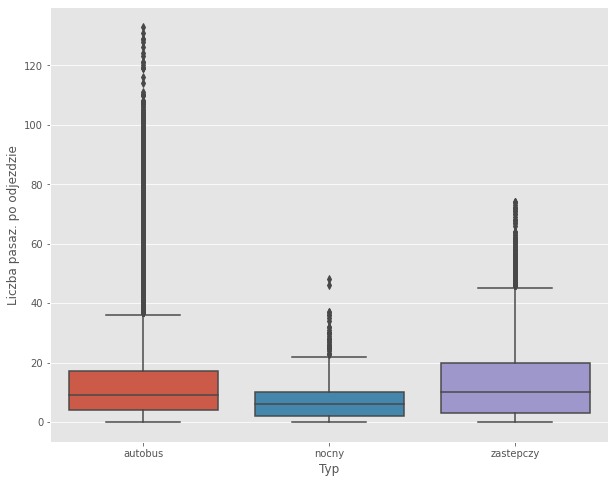

In [108]:
plt.figure(figsize=(10, 8))
ax = sns.boxplot(
    y='Liczba pasaz. po odjezdzie',
    x='Typ',
    data=df
)

<Figure size 432x288 with 0 Axes>

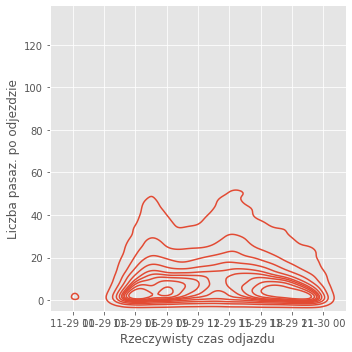

In [115]:
plt.figure()
ax = sns.displot(
    df,
    x='Rzeczywisty czas odjazdu',
    y='Liczba pasaz. po odjezdzie',
    kind='kde'
)

<Figure size 432x288 with 0 Axes>

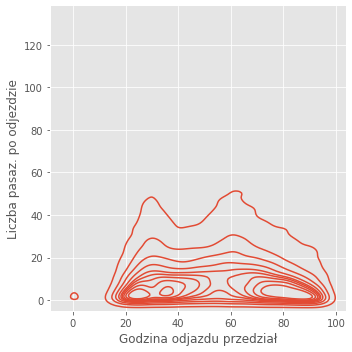

In [118]:
plt.figure()
ax = sns.displot(
    df,
    x='Godzina odjazdu przedział',
    y='Liczba pasaz. po odjezdzie',
    kind='kde'
)

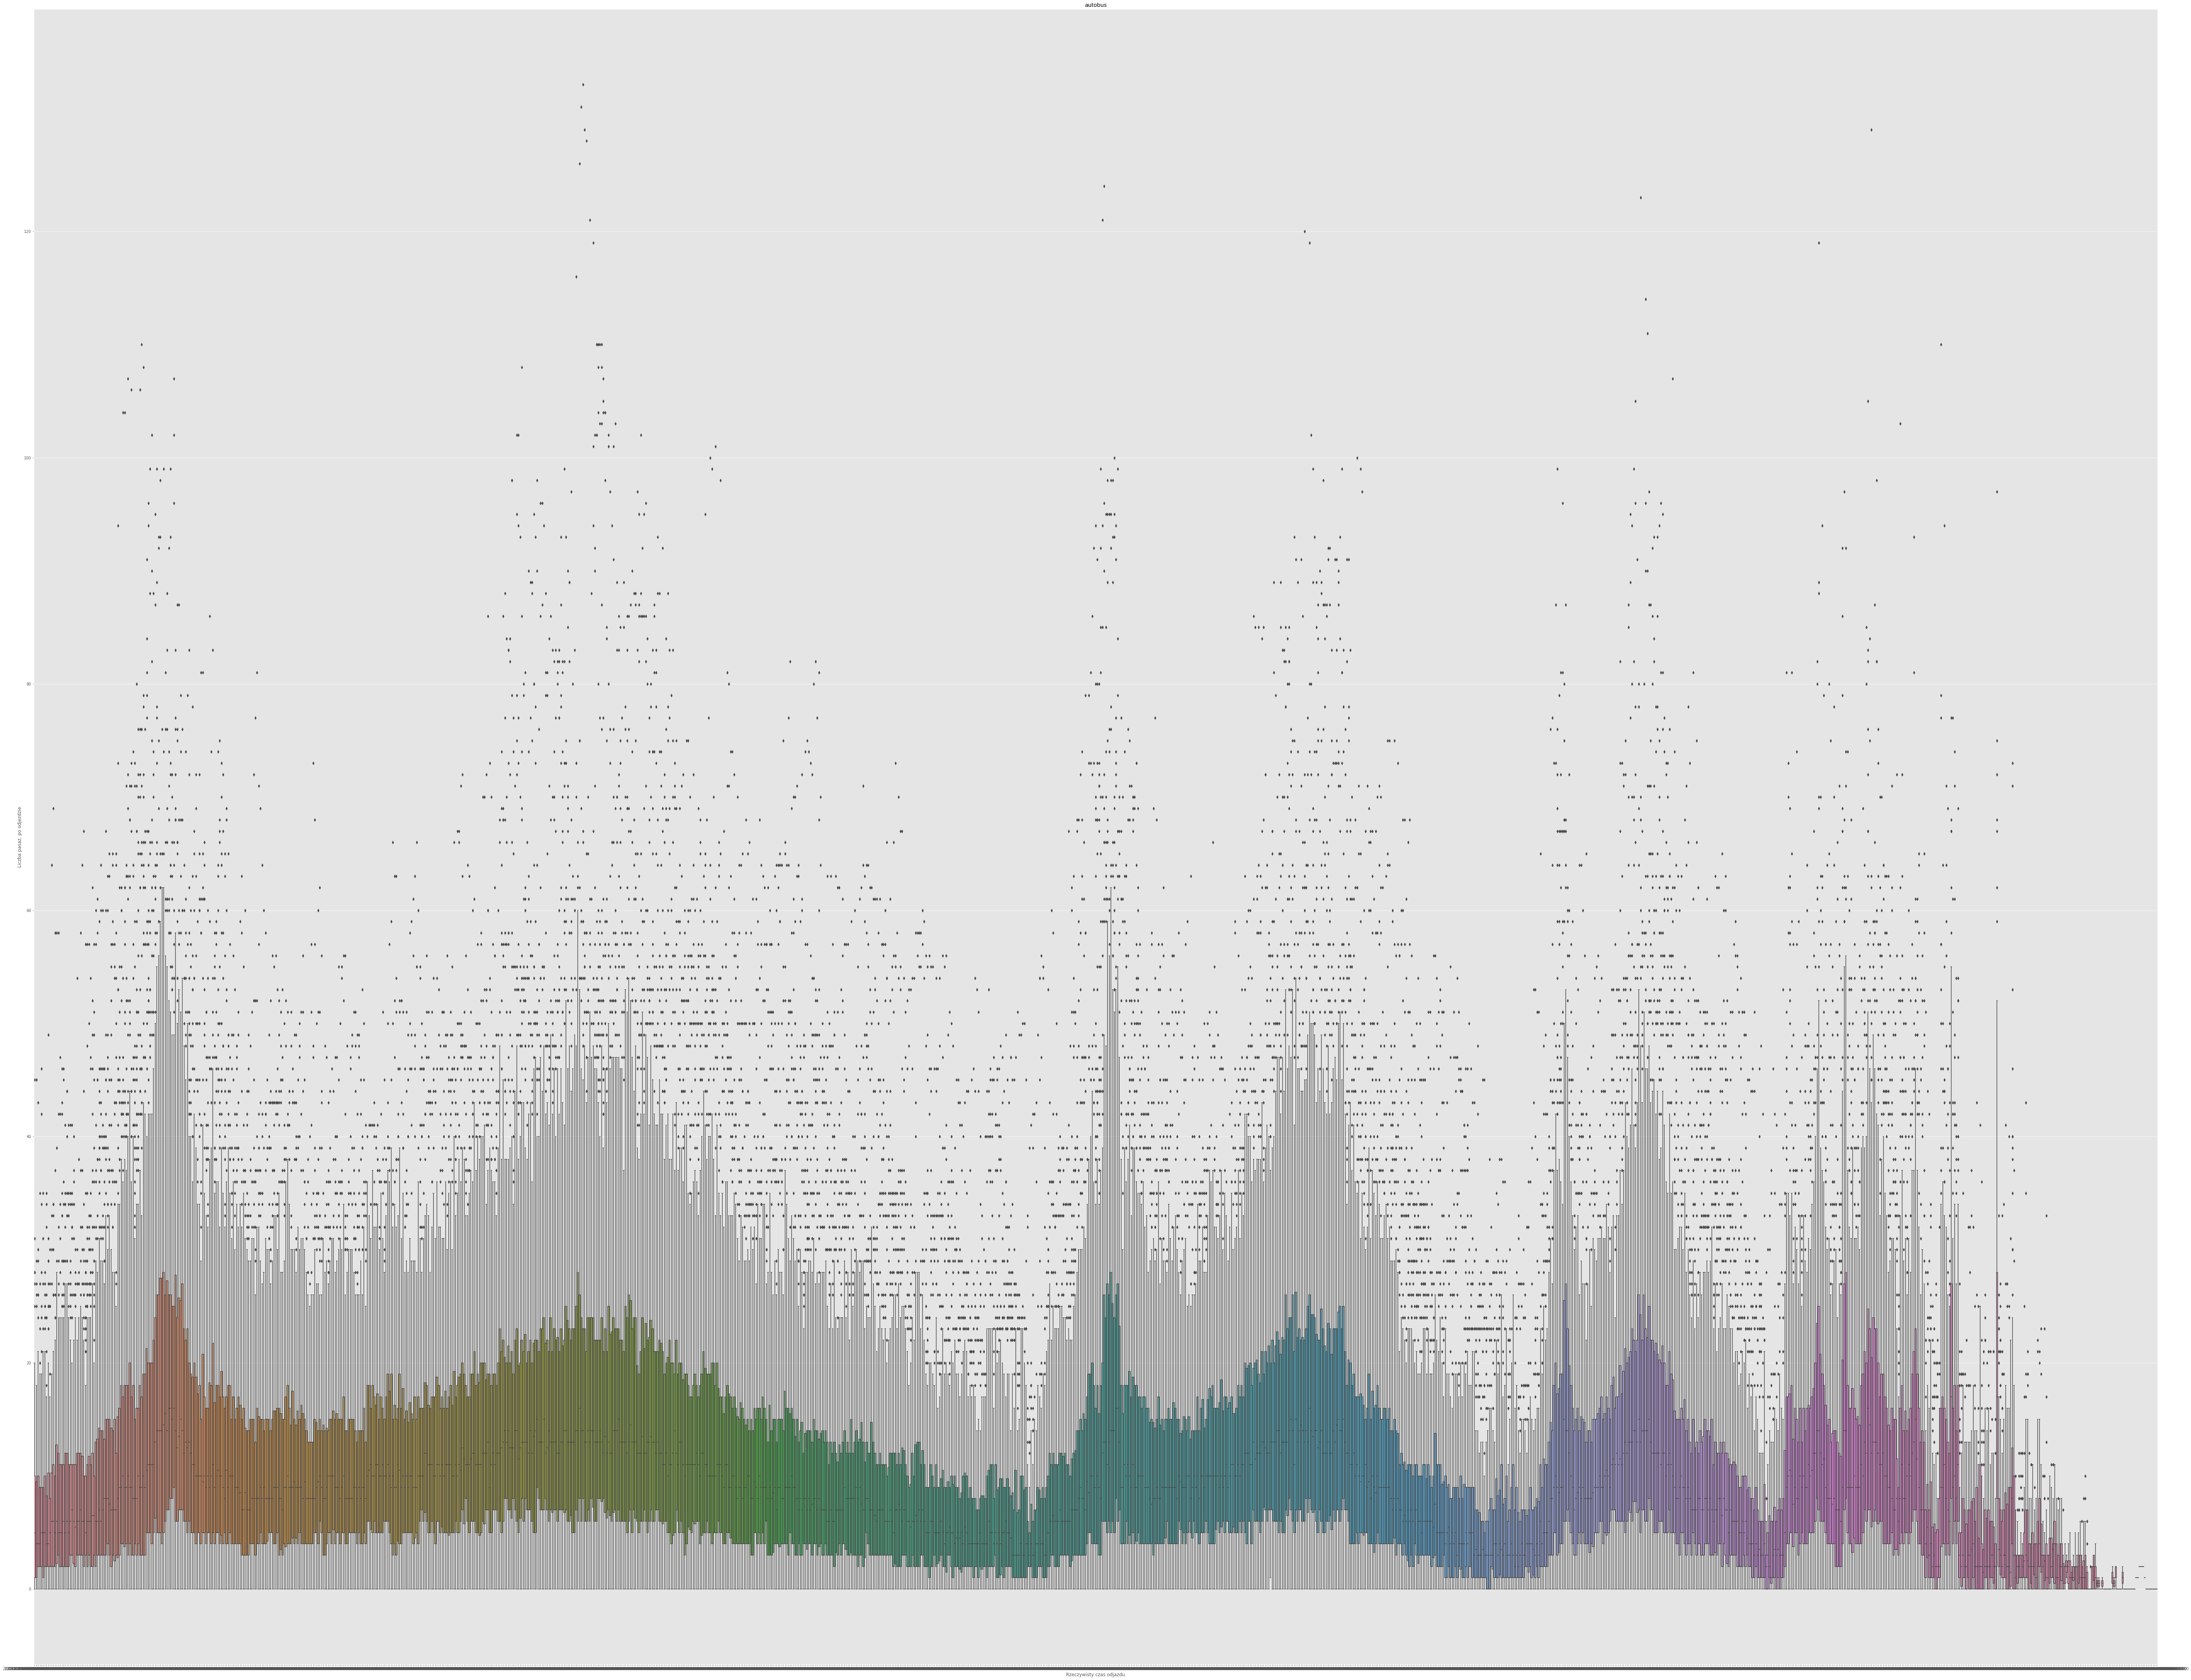

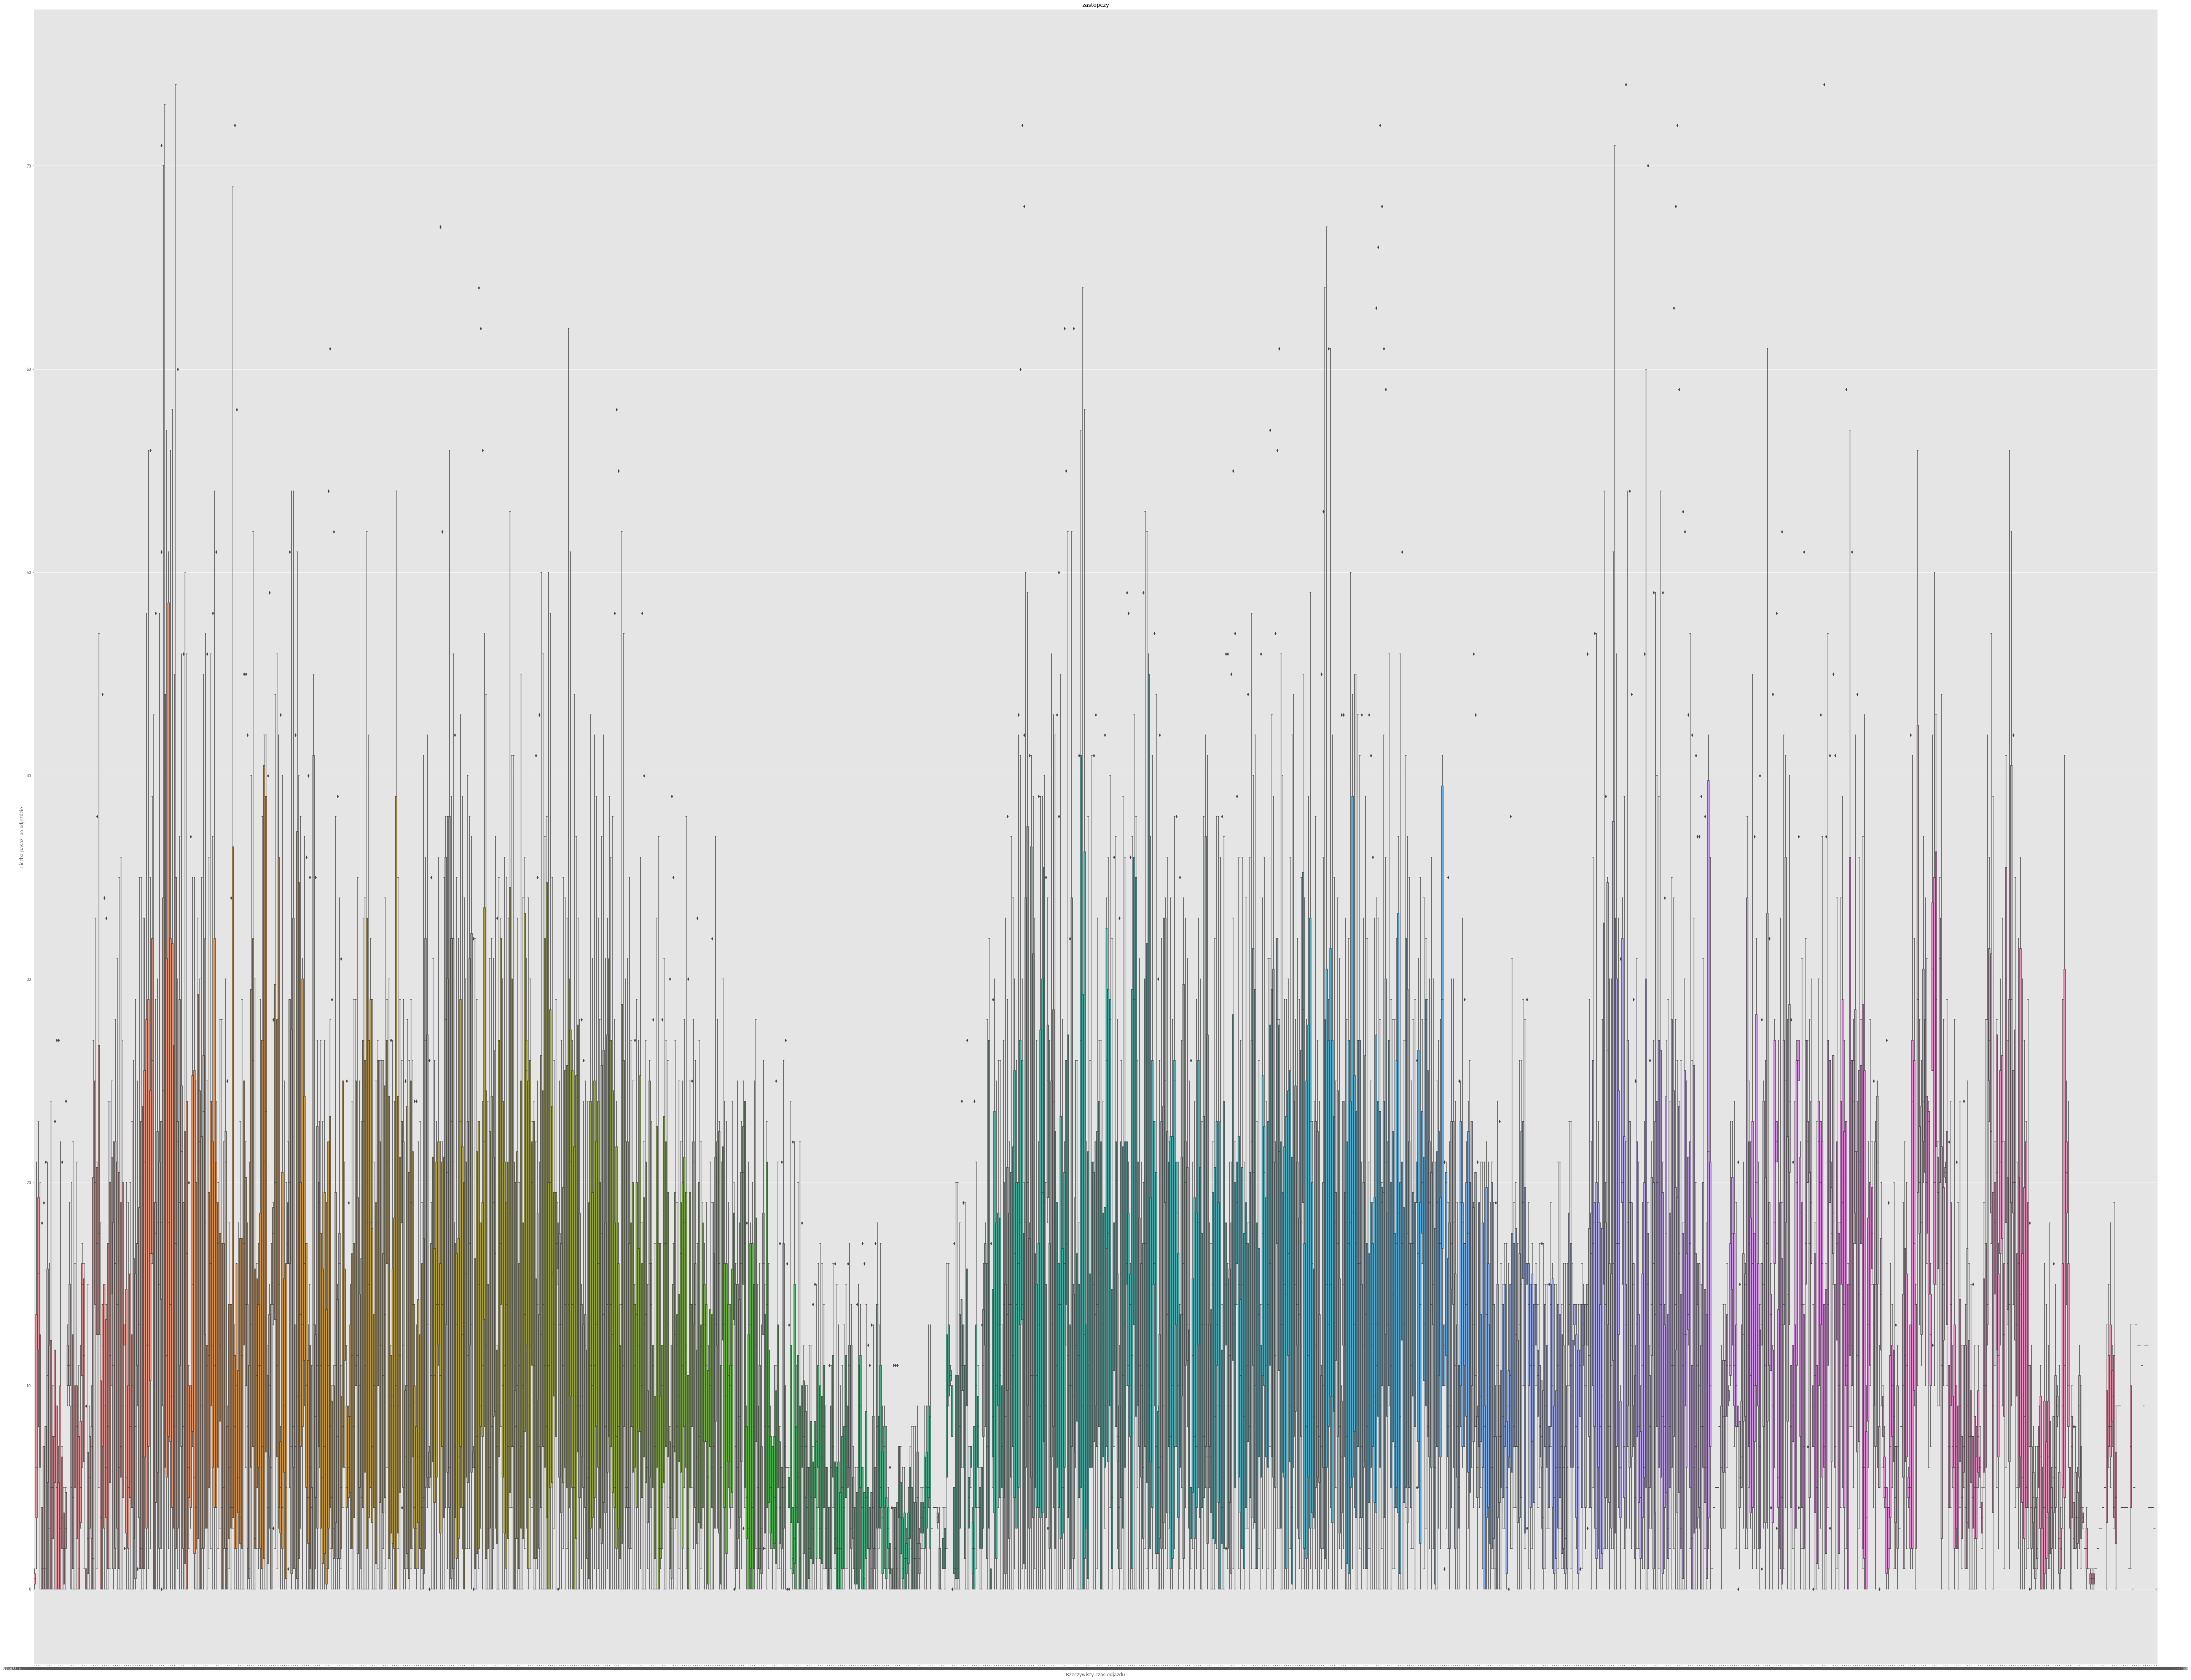

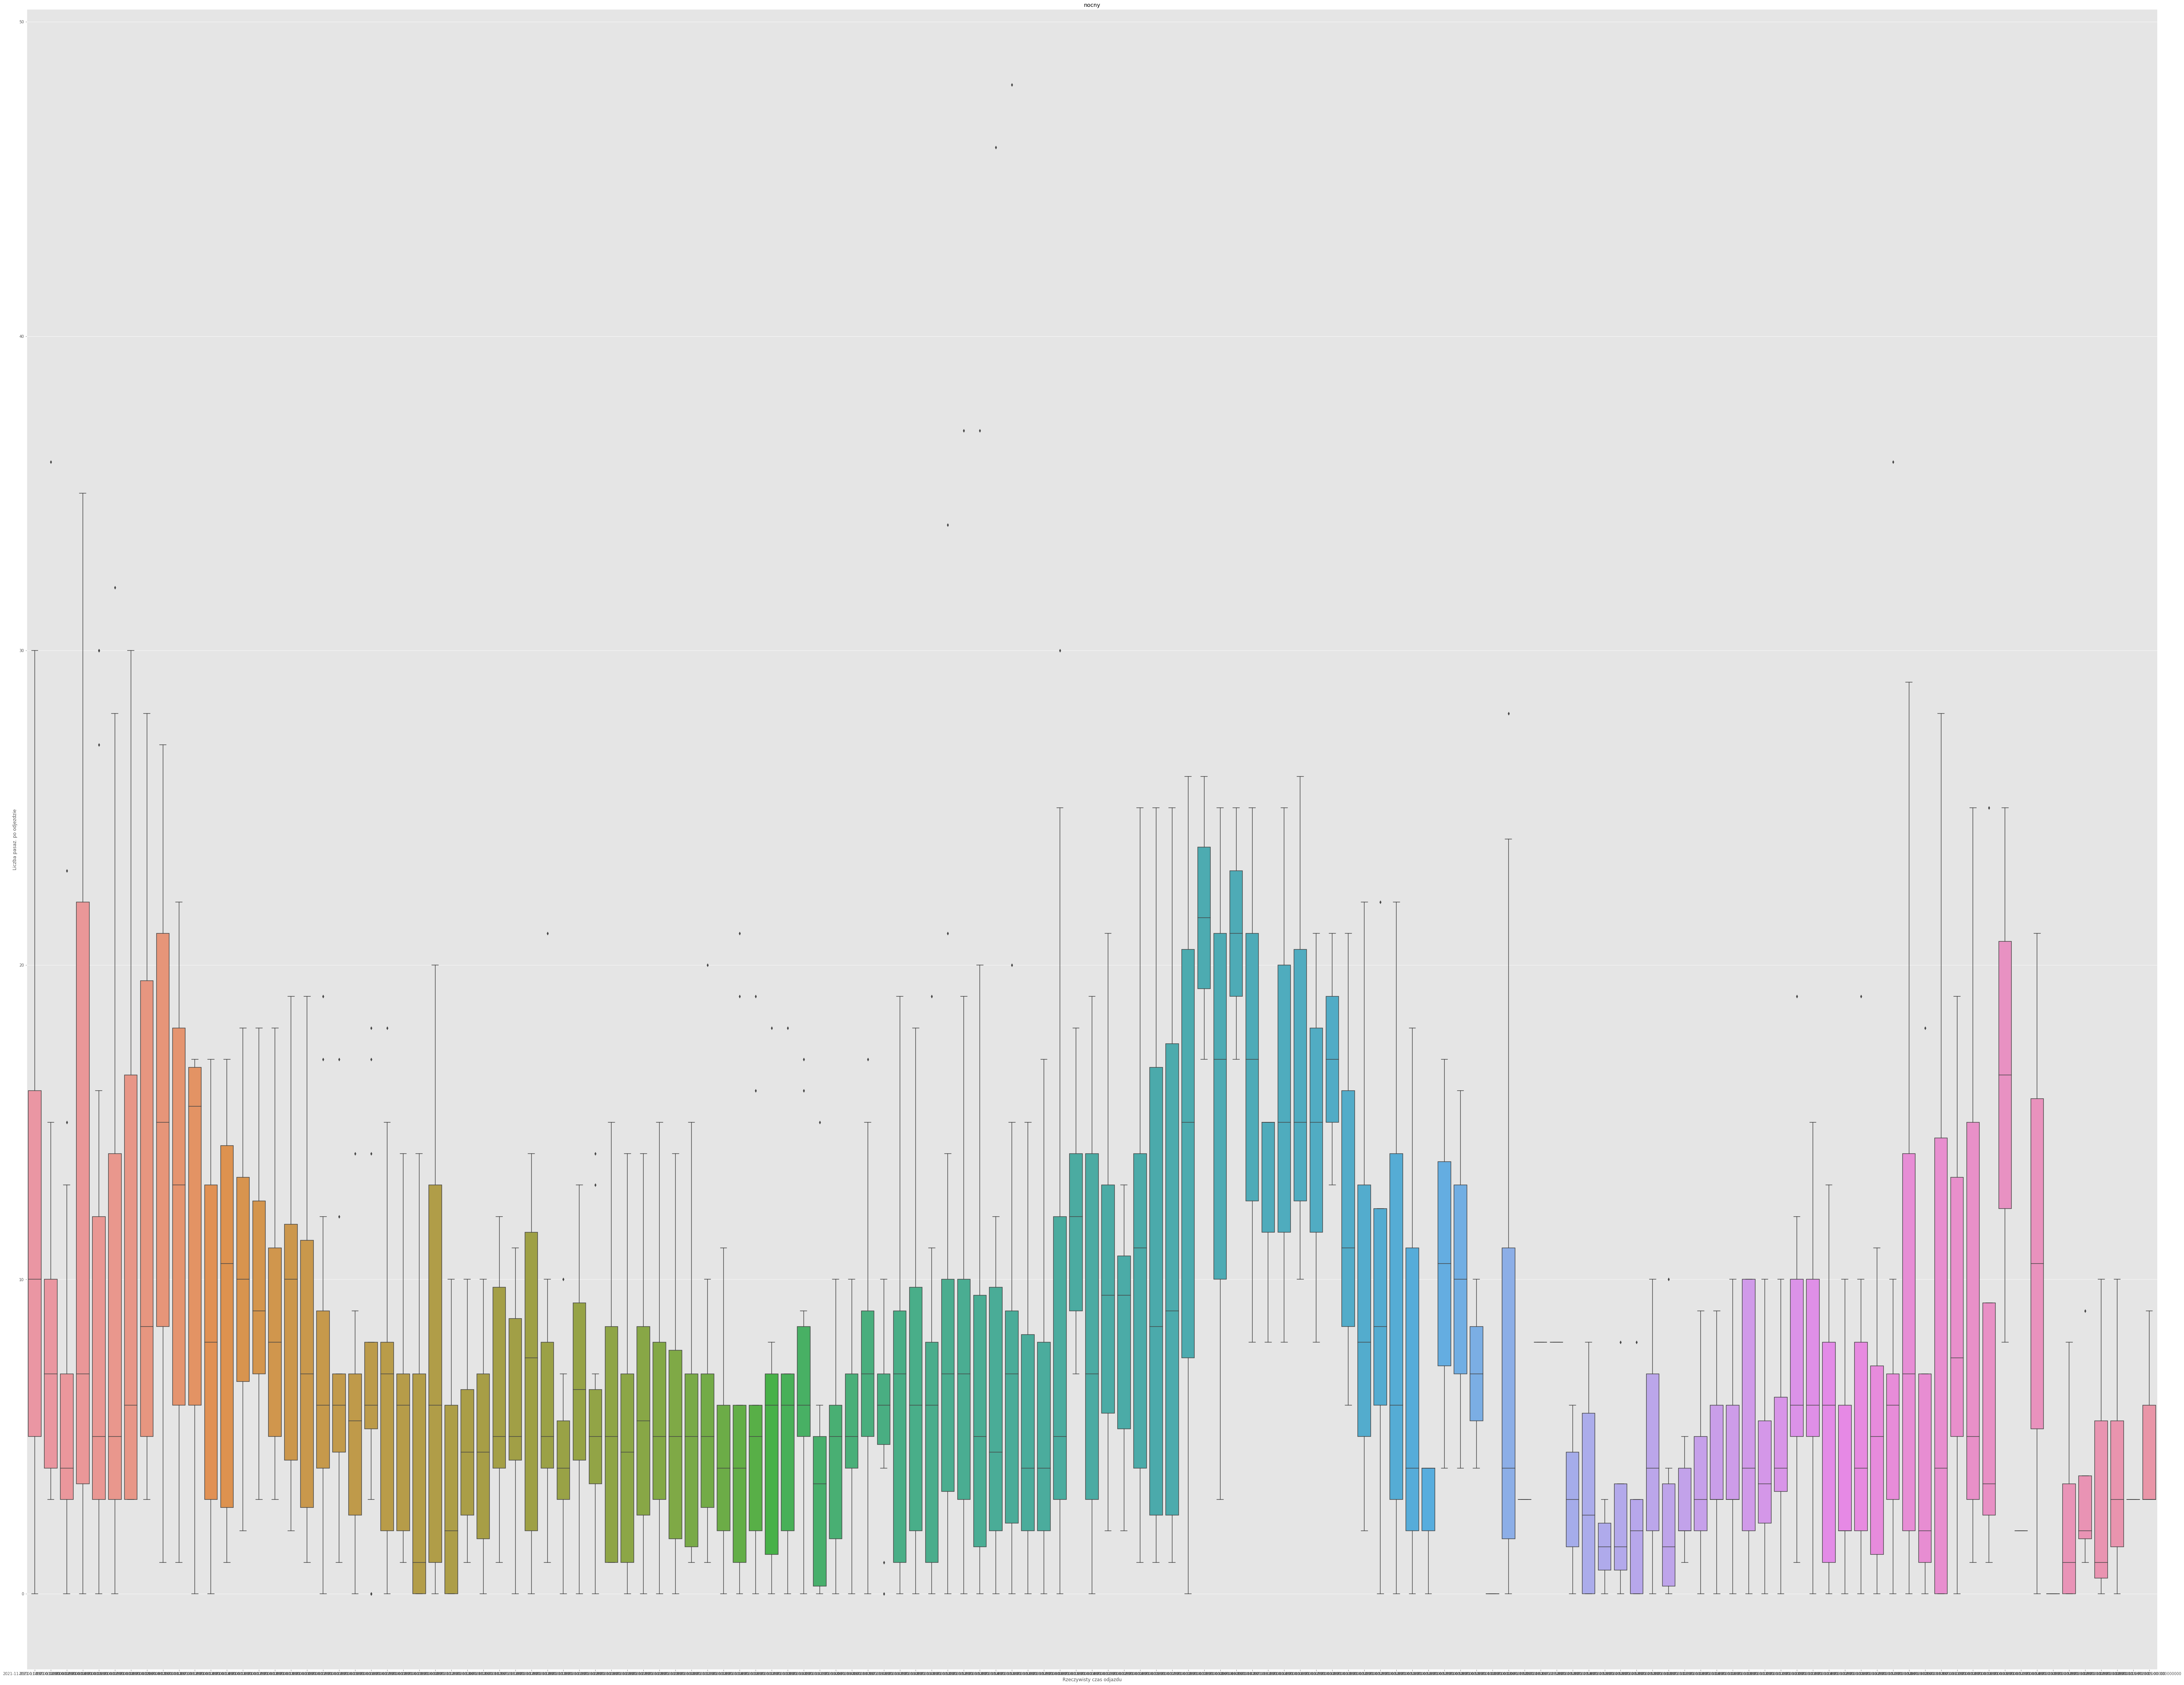

In [19]:
for trans_type in ['autobus', 'zastepczy', 'nocny']:
    plt.figure(figsize=(100, 80))
    ax = sns.boxplot(
        x='Rzeczywisty czas odjazdu',
        y='Liczba pasaz. po odjezdzie',
        data=df.loc[df['Typ']==trans_type]
    )
    ax.set_title(trans_type)

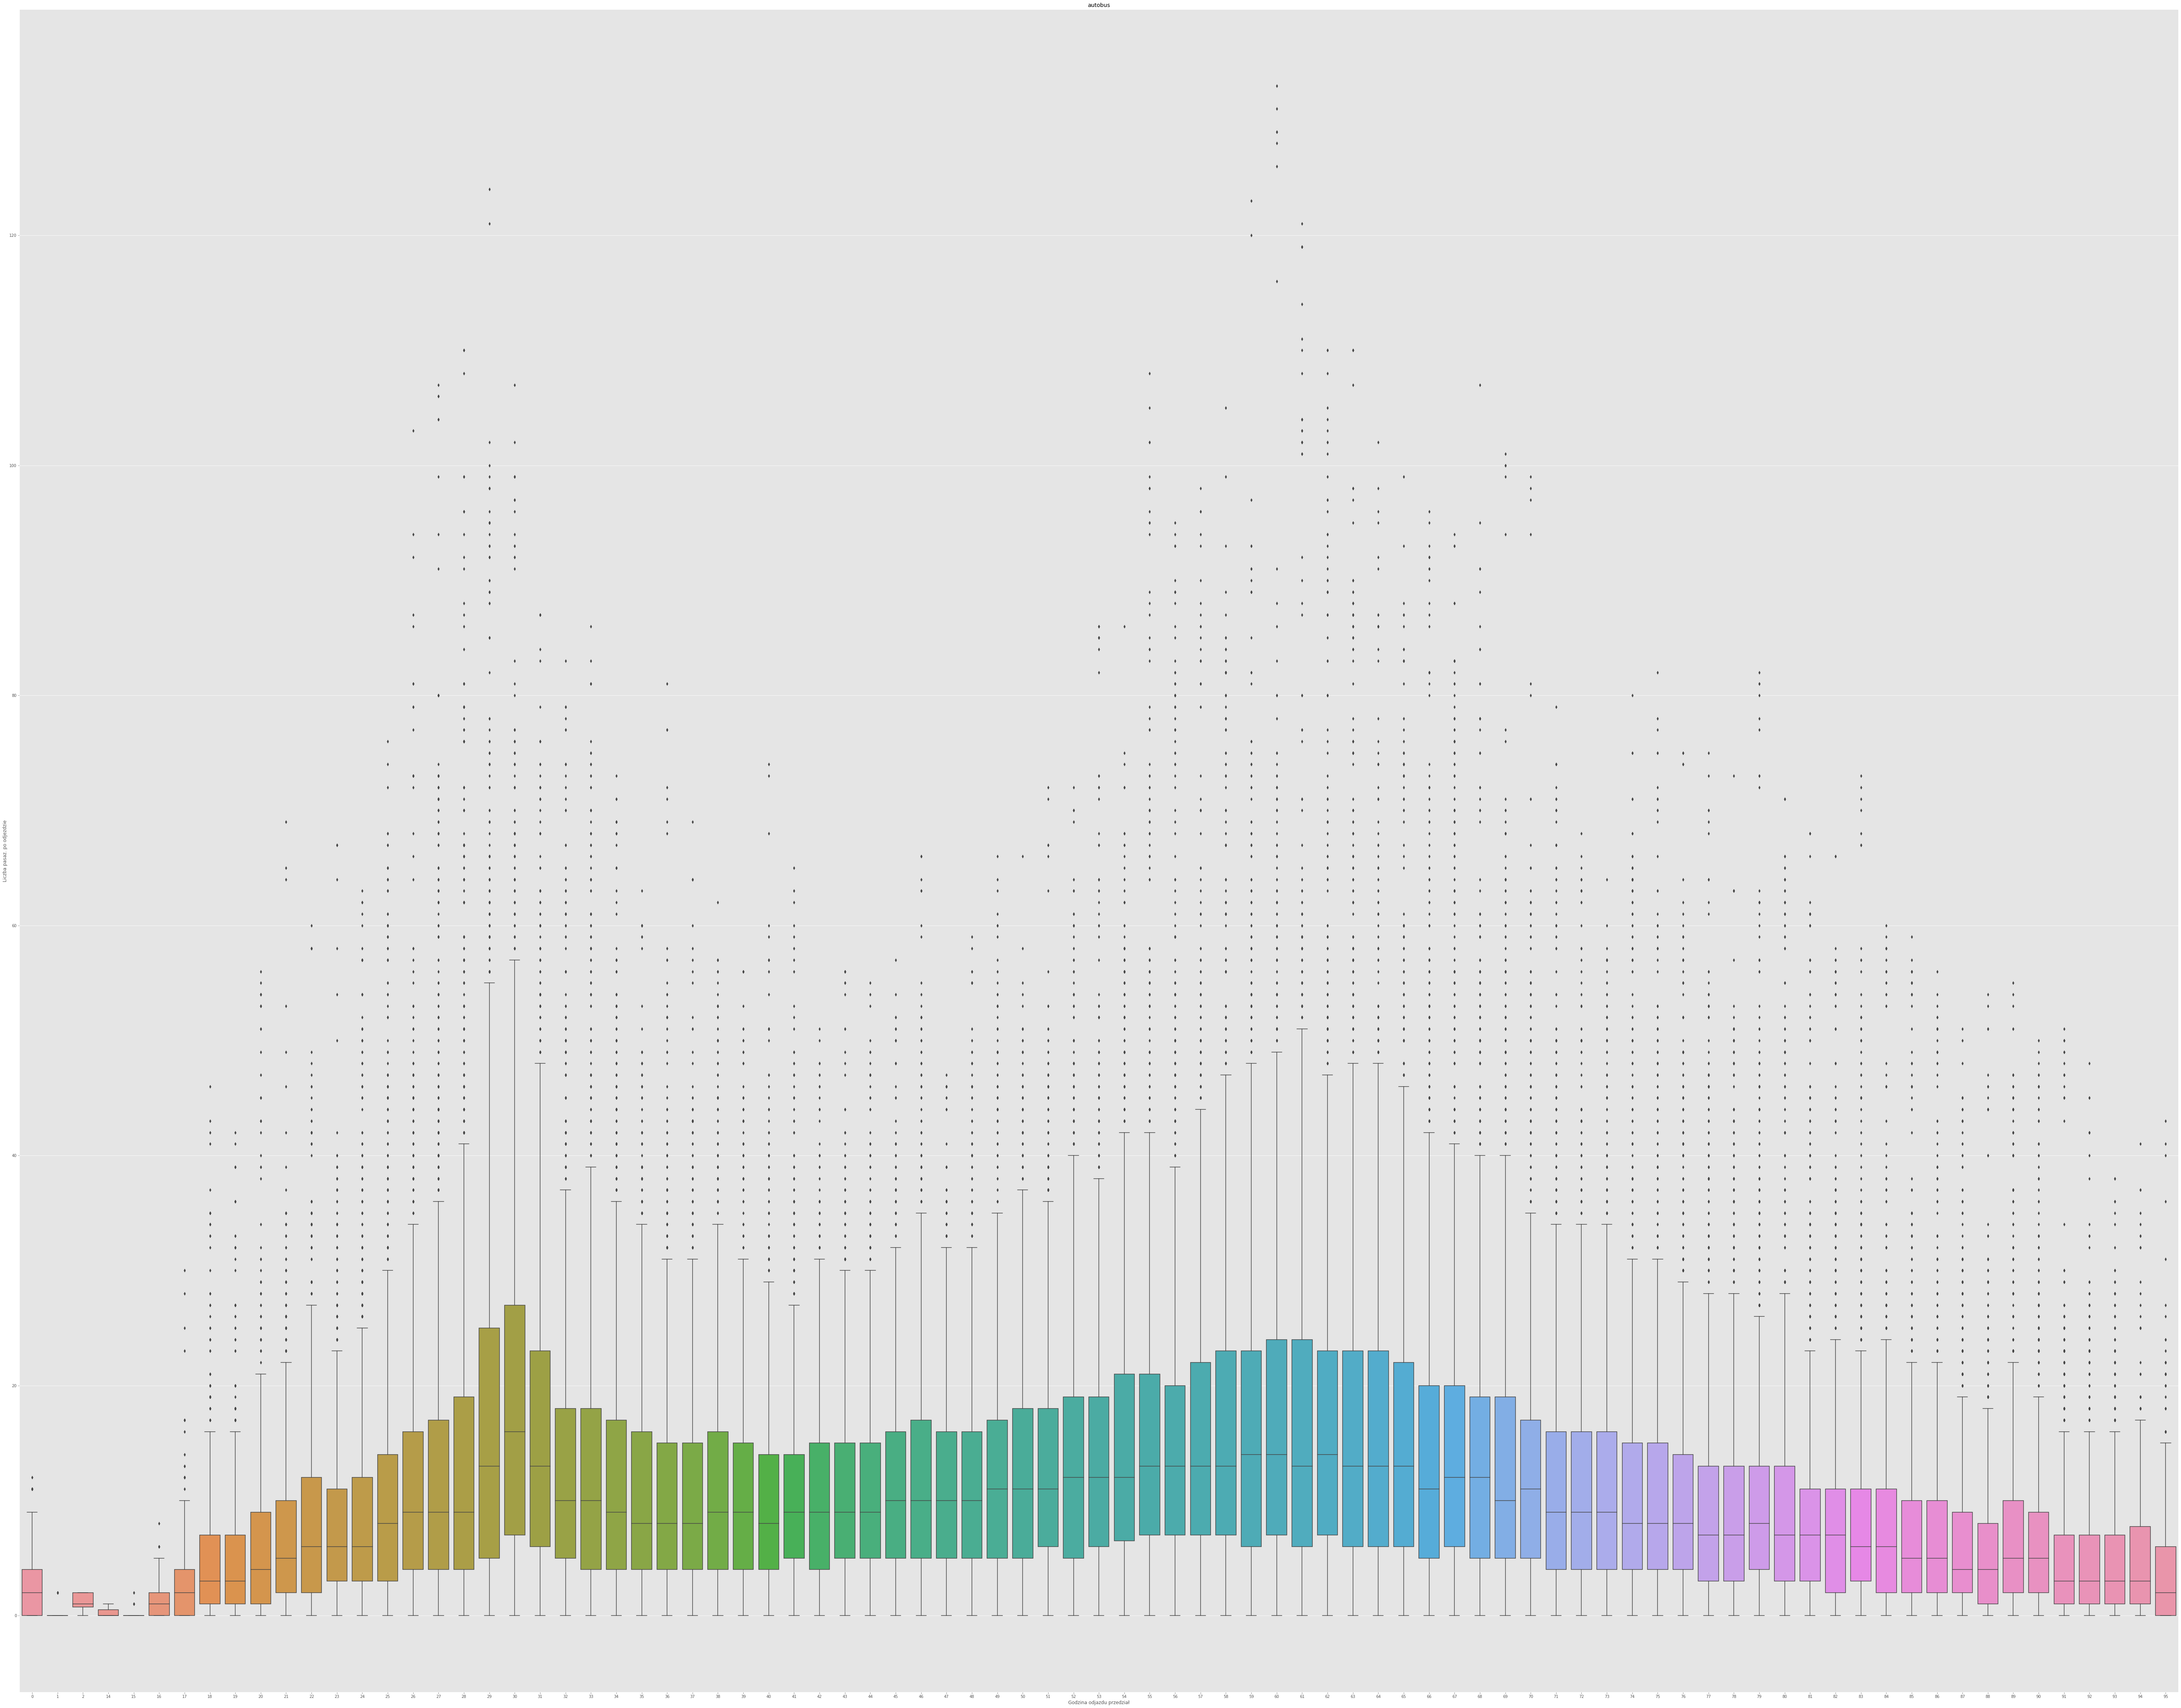

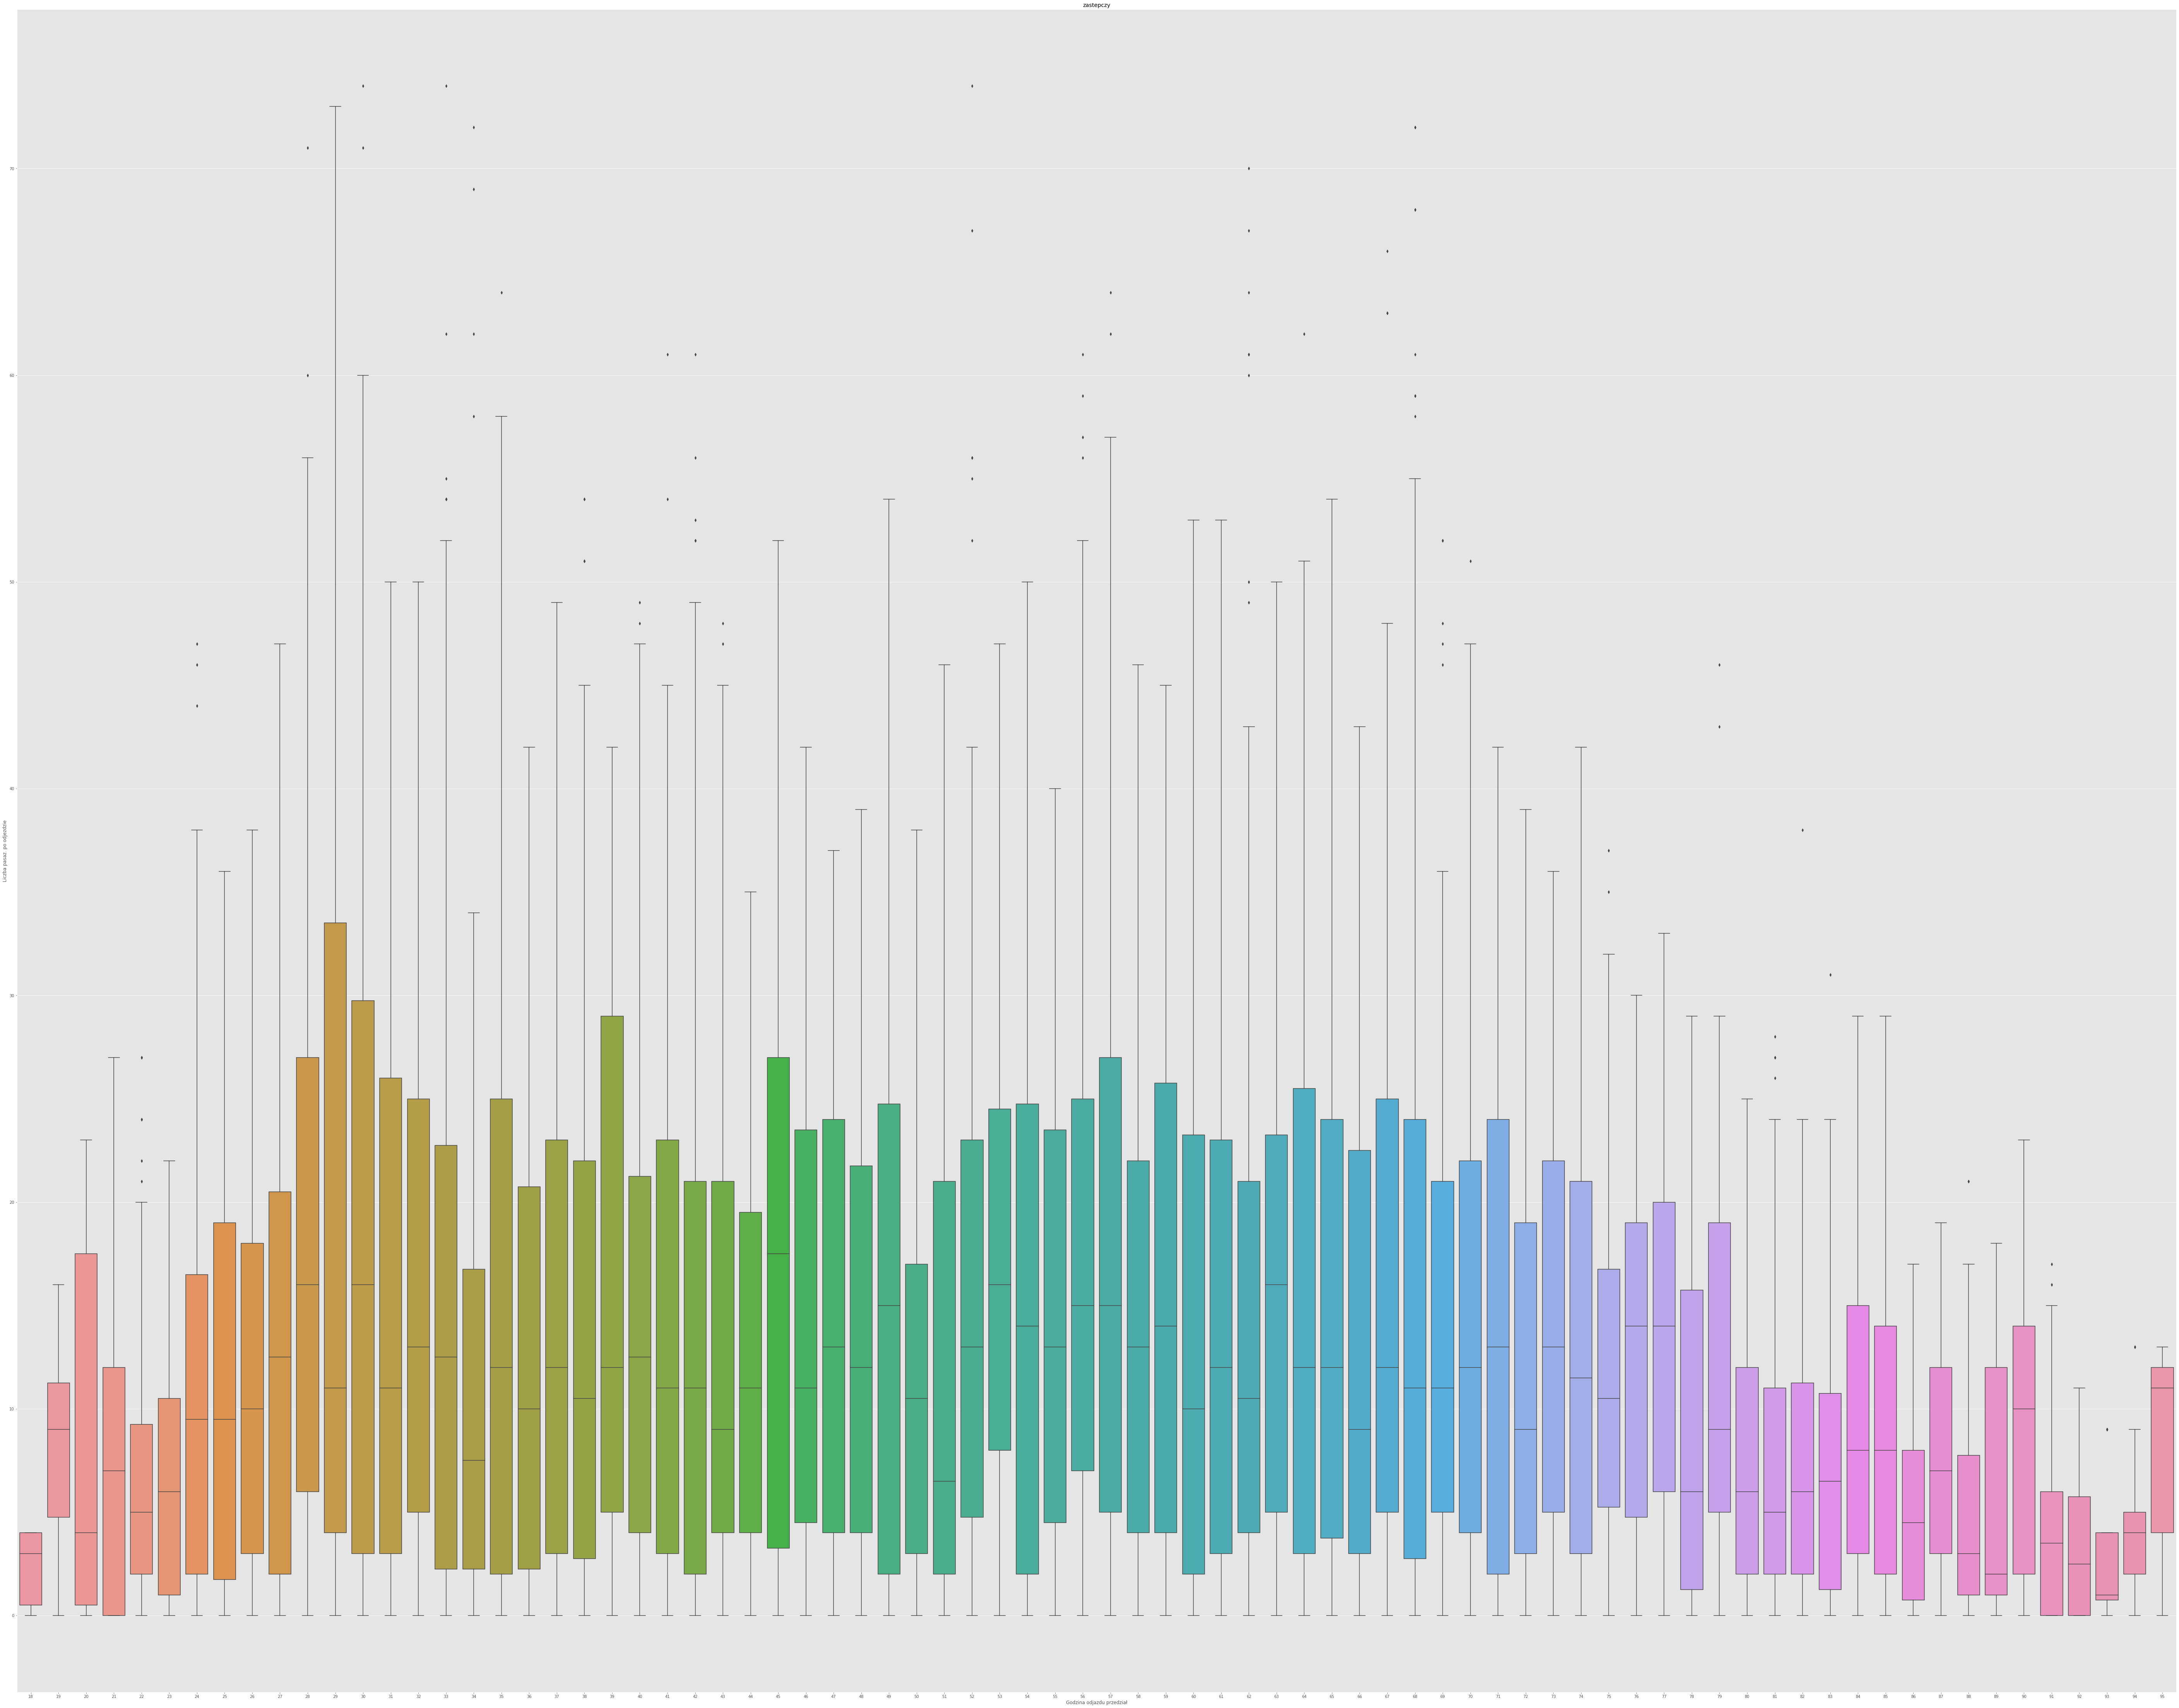

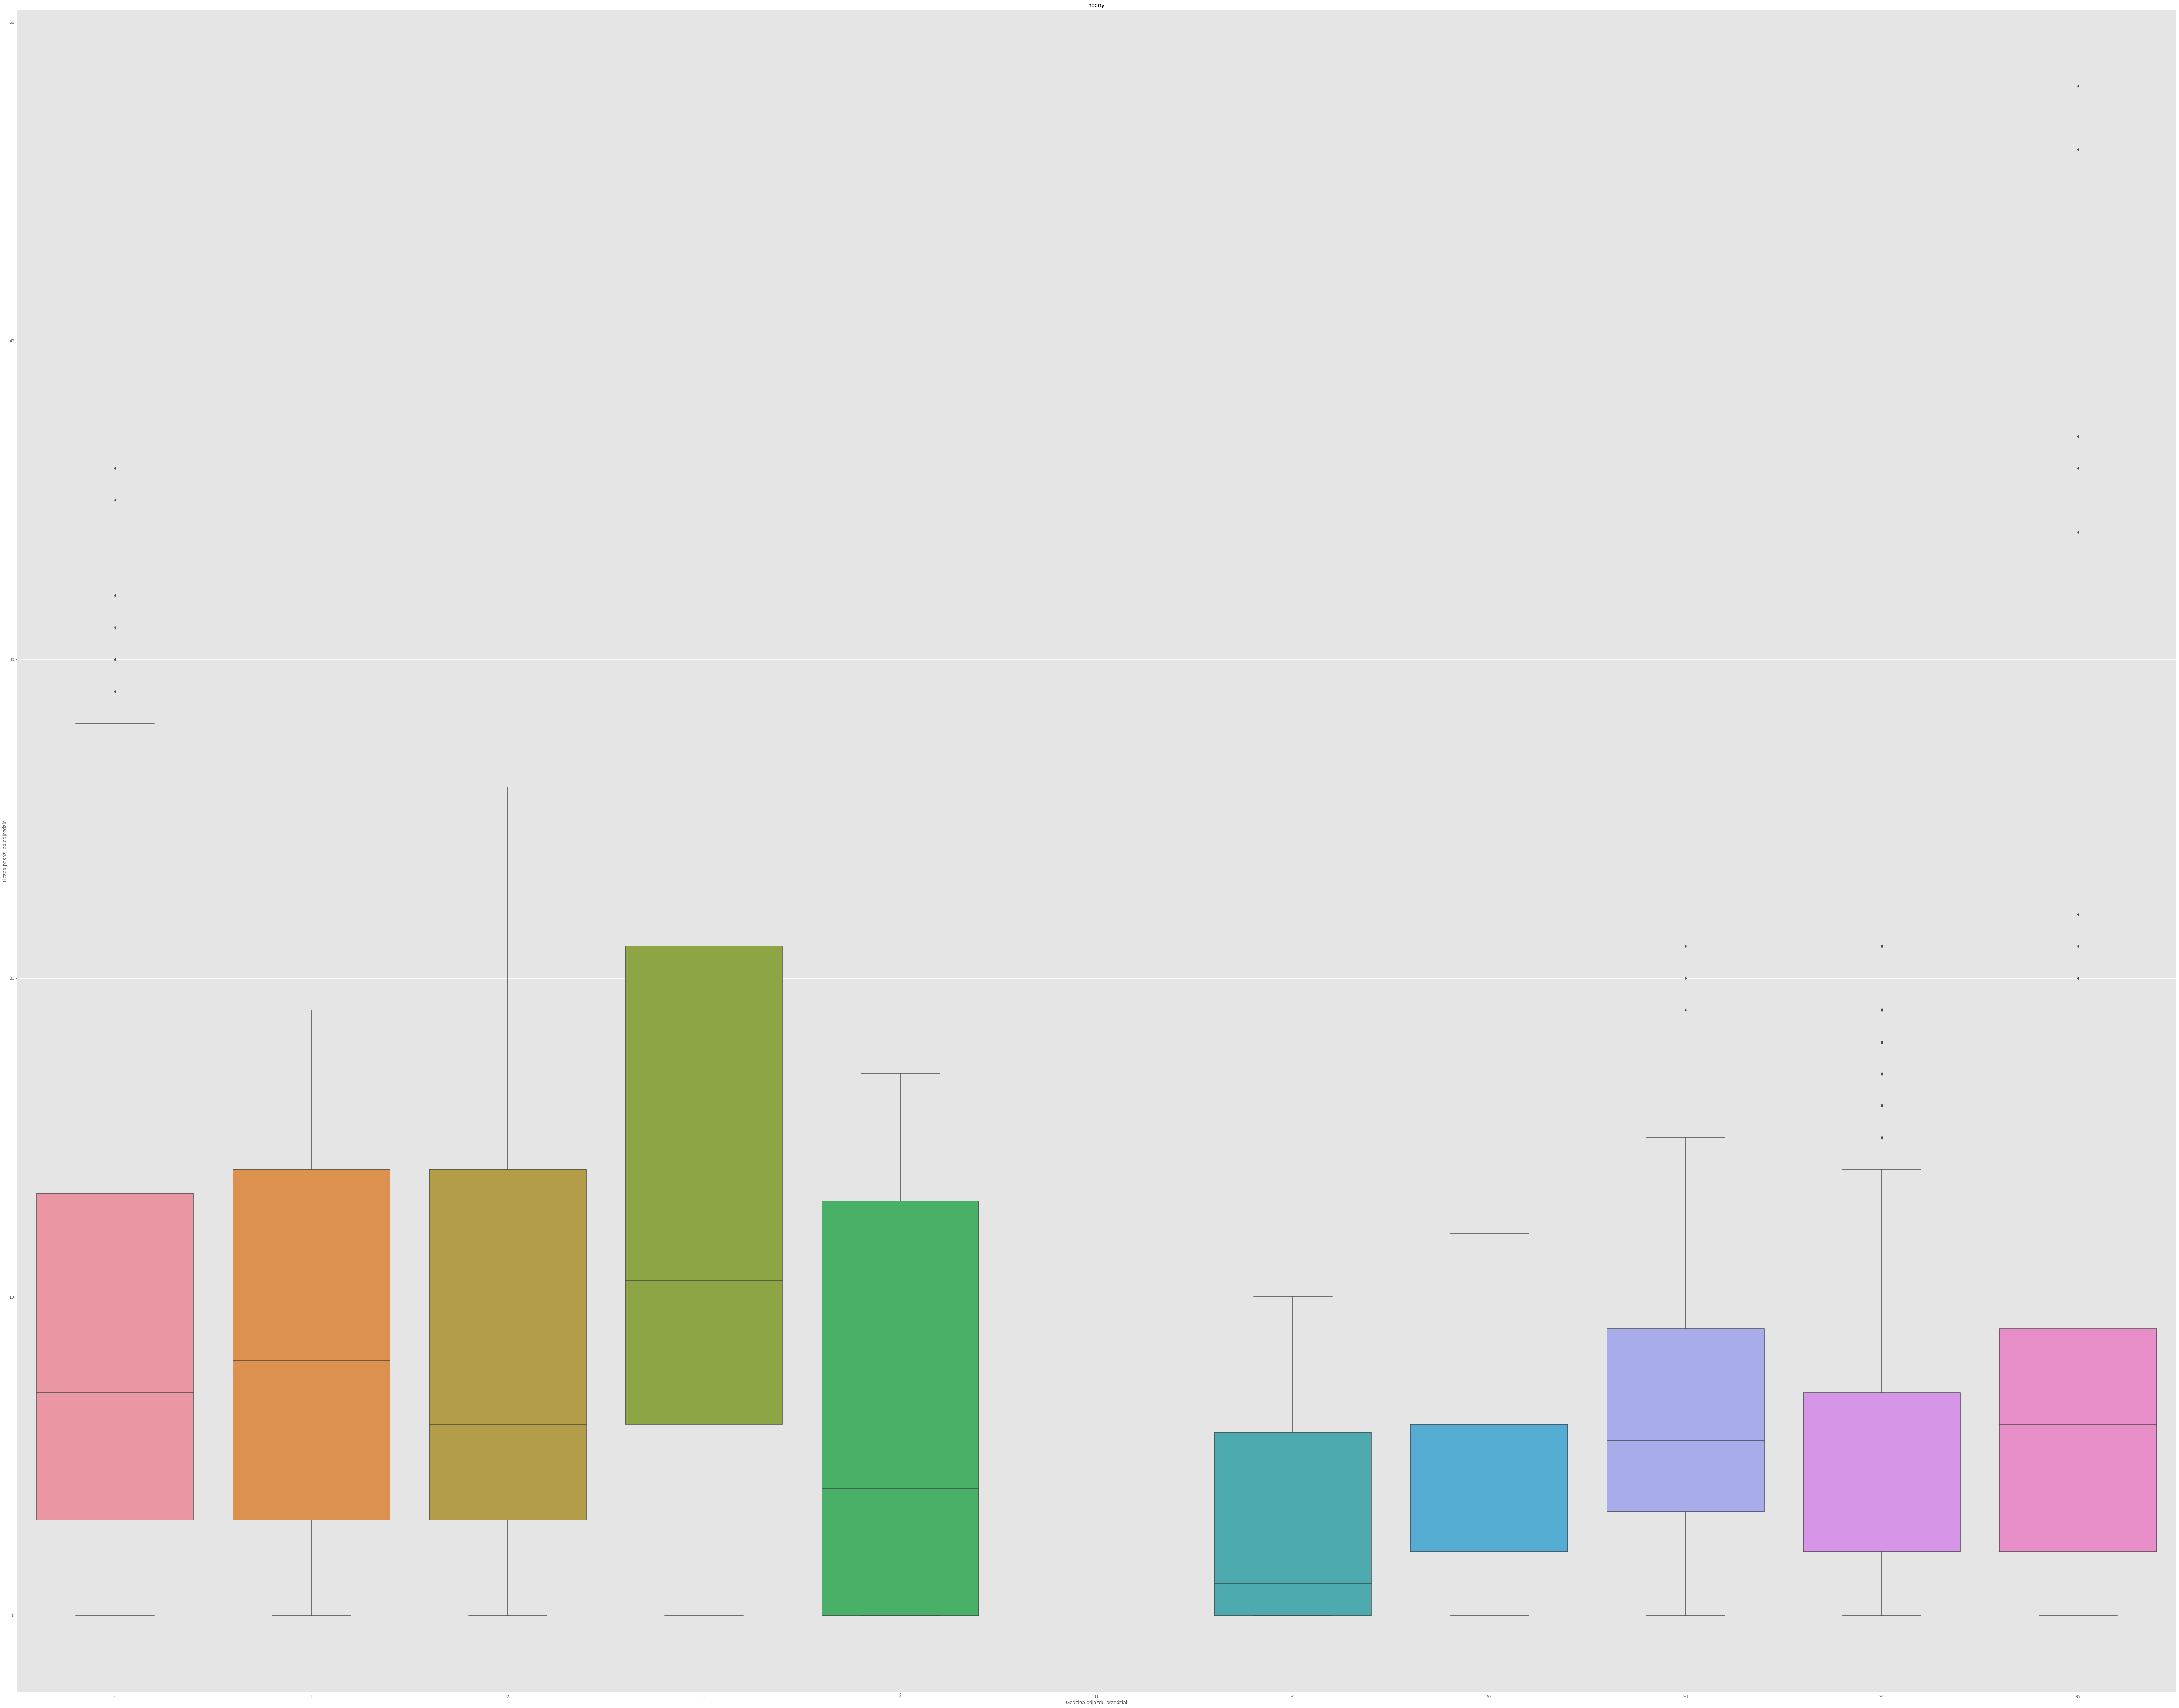

In [119]:
for trans_type in ['autobus', 'zastepczy', 'nocny']:
    plt.figure(figsize=(100, 80))
    ax = sns.boxplot(
        x='Godzina odjazdu przedział',
        y='Liczba pasaz. po odjezdzie',
        data=df.loc[df['Typ']==trans_type]
    )
    ax.set_title(trans_type)

# 5.1. Porównanie wybranych lini do globalnego podejscia

In [53]:
df_no_type = df.drop(df[df['Typ'] != 'autobus'].index, inplace= False)
df_no_type.drop(columns=['Typ'], inplace= True)
df_no_type.sample(5)

Nr linii Wariant linii                Kurs Oznaczenie brygady  \
83071       193        TP-UPN 2021-11-29 20:30:00                  4   
70063       181        TP-PLW 2021-11-29 17:29:00                  3   
108556      211        TX-DWI 2021-11-29 14:38:00                 10   
135728      516        TP-FSO 2021-11-29 16:31:00                  5   
81100       193        TP-BOK 2021-11-29 14:57:00                  1   

        Numer taborowy Nazwa przystanku  Numer przystanku  \
83071             9925     Metro Służew                 1   
70063             9548   Dzierżoniowska                 1   
108556            9085     Dzierzgońska                 1   
135728            9414     Płochocińska                 1   
81100             9924     Ursynów Płd.                 1   

       Rzeczywisty czas odjazdu Rozkładowy czas odjazdu  Liczba pasaz. przed  \
83071       2021-11-29 20:39:00     2021-11-29 20:40:00                    9   
70063       2021-11-29 17:35:00     2021-11-29 17:35:00                   13   
108556      2021-11-29 14:43:00     2021-11-29 14:46:00                   47   
135728      2021-11-29 16:52:00     2021-11-29 16:56:00                    6   
81100       2021-11-29 15:02:00     2021-11-29 15:04:00                    7   

        Liczba wysiadających pasaz.  Liczba wsiadajacych pasaz.  \
83071                             7                           0   
70063                             0                           1   
108556                           22                           8   
135728                            1                           1   
81100                             1                           5   

        Liczba pasaz. po odjezdzie  Godzina odjazdu  \
83071                            2        20.666667   
70063                           14        17.583333   
108556                          33        14.766667   
135728                           6        16.933333   
81100                           11        15.066667   

        Godzina odjazdu przedział             class  
83071                          82             pusto  
70063                          70  małe zatłoczenie  
108556                         59  duze zatłoczenie  
135728                         67             pusto  
81100                          60  małe zatłoczenie

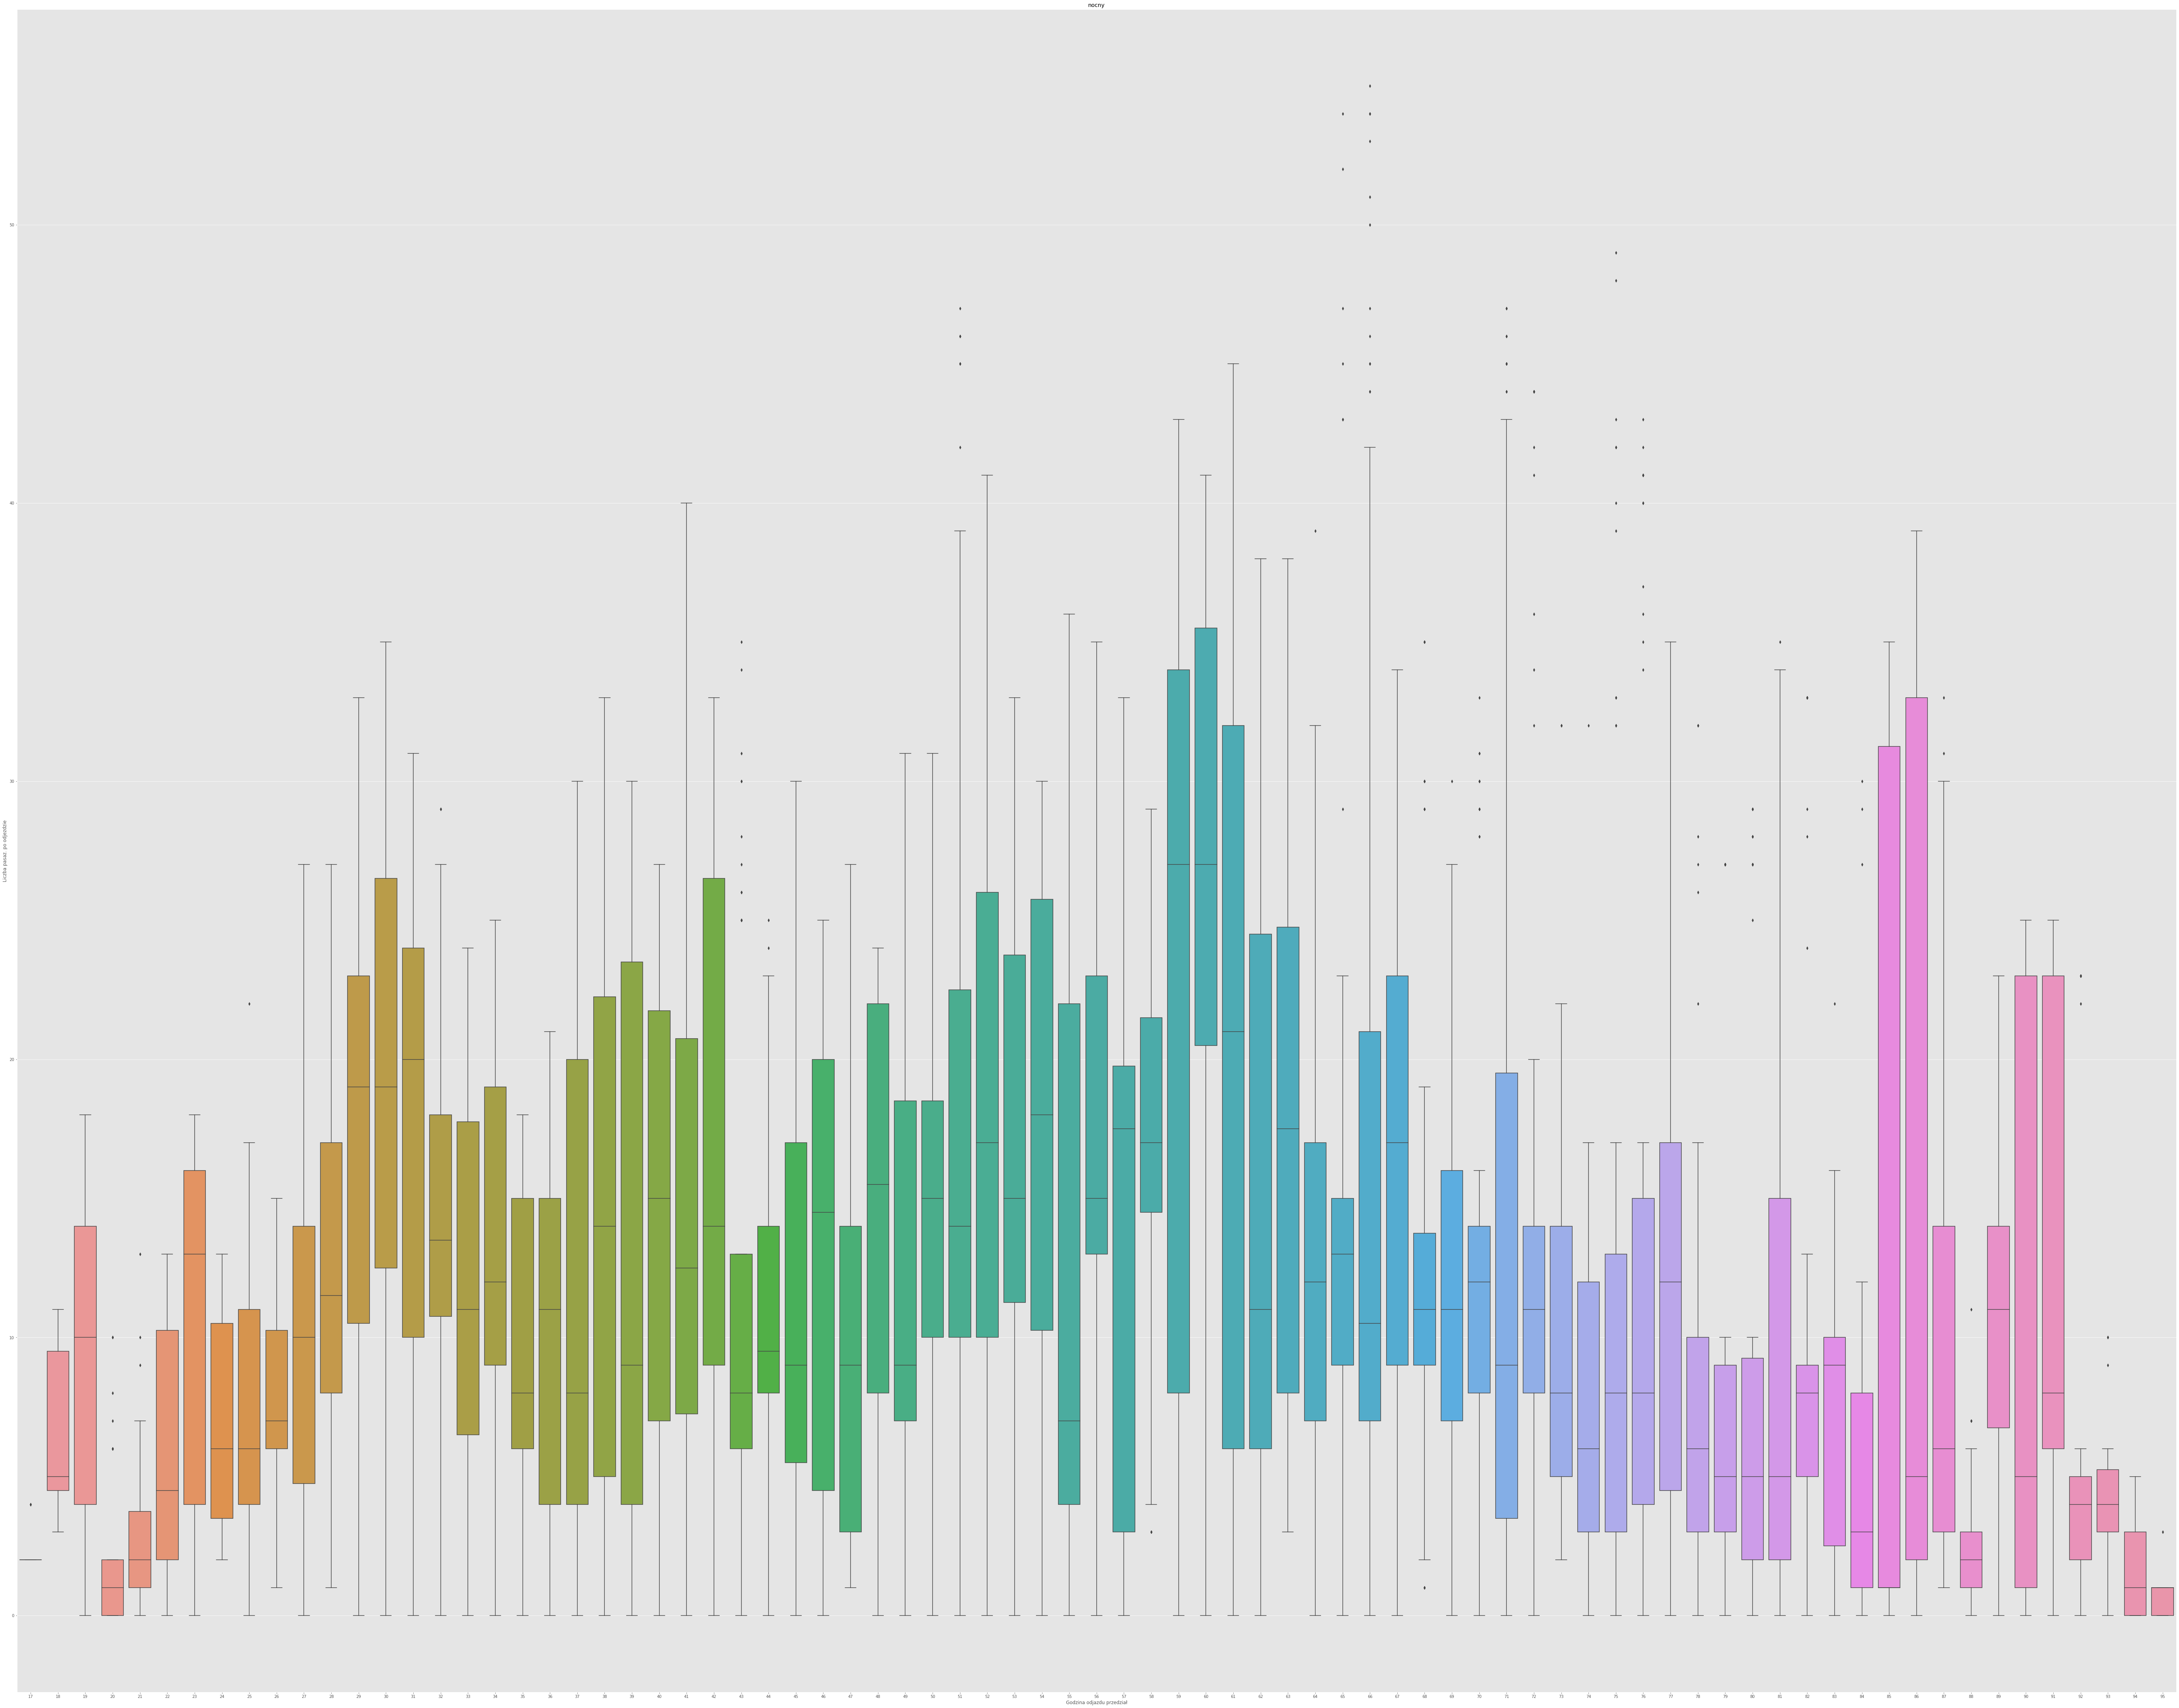

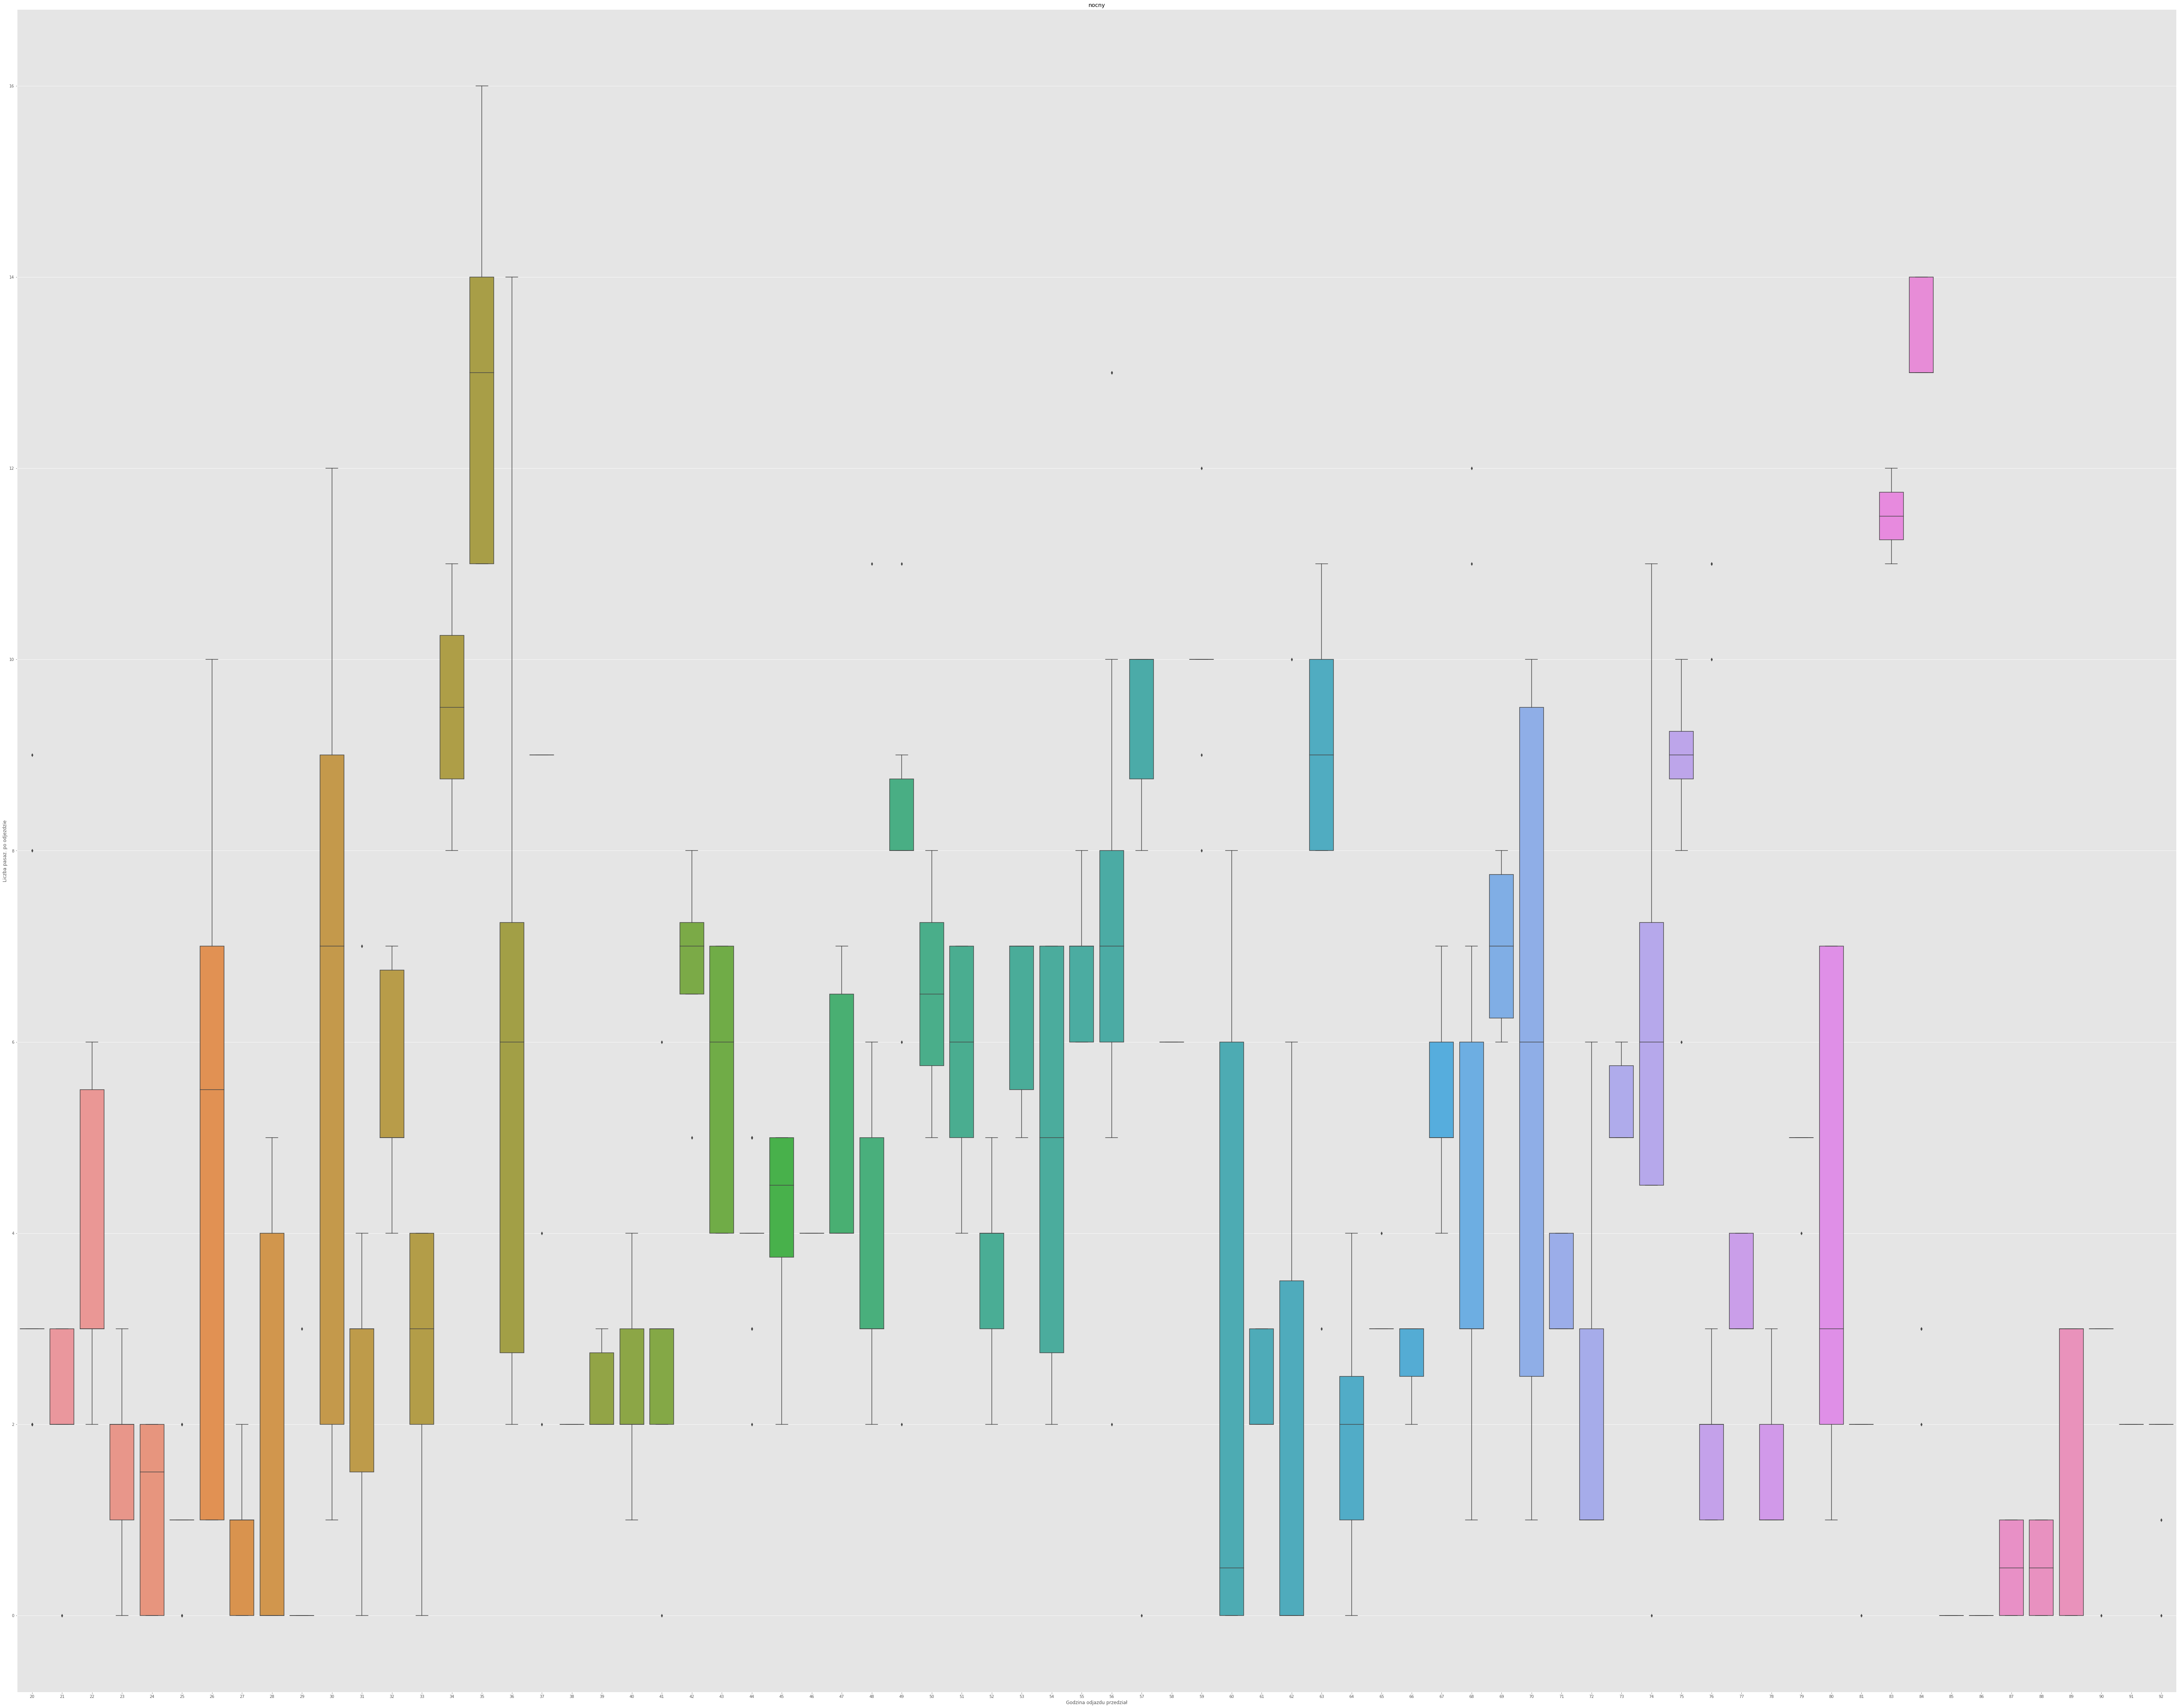

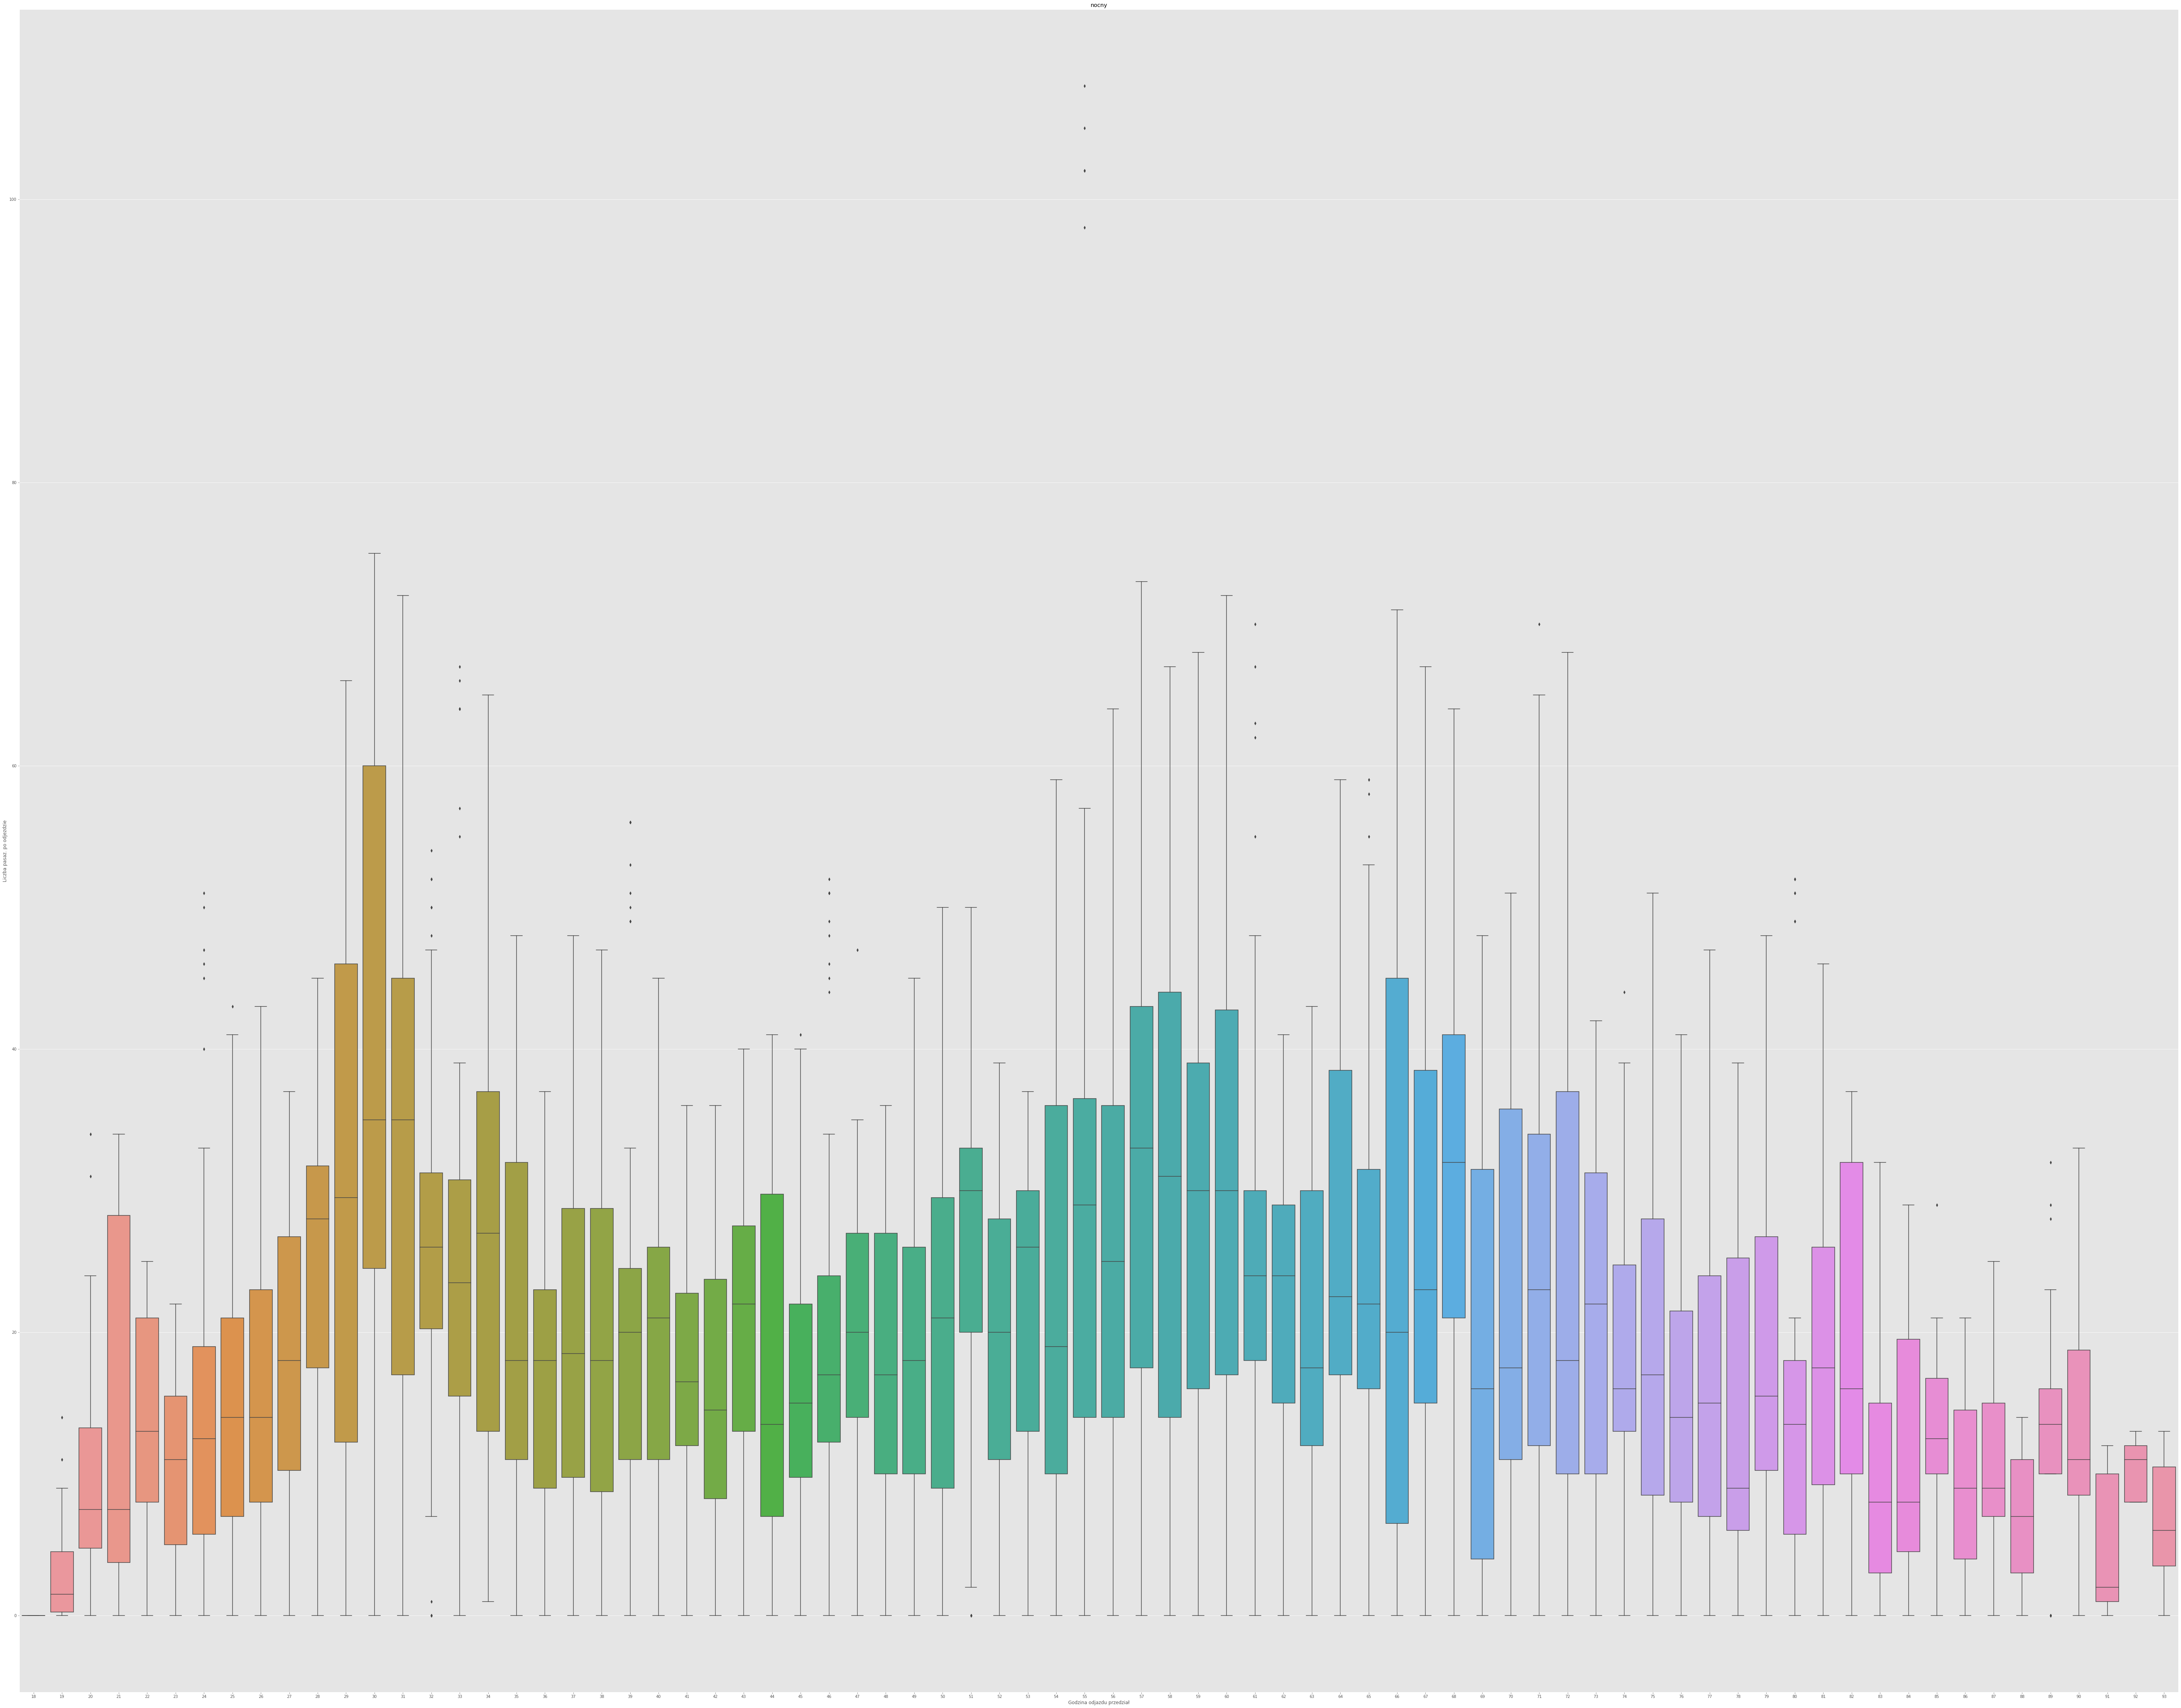

In [129]:
for line_number in ['142', '264', '525']:
    plt.figure(figsize=(100, 80))
    ax = sns.boxplot(
        x='Godzina odjazdu przedział',
        y='Liczba pasaz. po odjezdzie',
        data=df_no_type.loc[df['Nr linii']==line_number]
    )
    ax.set_title(trans_type)

# 6. Clustering

In [18]:
def find_clusters(speeds, iterations, df, column):
    k = len(speeds)
    data = np.array(df[column]).reshape(1,-1).T
    clusters = KMeans(
        n_clusters = k,
        max_iter = iterations,
        random_state = RANDOM_SEED
    ).fit(data)
    
    cc, *_ = clusters.cluster_centers_.reshape(1,k)
    cc_ord = np.argsort(cc)
    class_mapping = dict(zip(cc_ord, speeds))
    
    df['class'] = clusters.labels_
    df['class'] = df['class'].map(class_mapping)
    
    return df

In [19]:
crowding = ['pusto','małe zatłoczenie', 'średnie zatłoczenie', 'duze zatłoczenie', 'olbrzymie zatłoczenie']
iterations = 10

df = find_clusters(crowding, iterations, df, 'Liczba pasaz. po odjezdzie')

<Figure size 720x576 with 0 Axes>

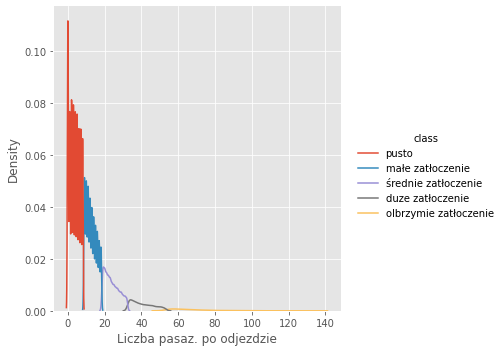

In [20]:
plt.figure(figsize=(10, 8))
ax = sns.displot(
    df,
    x='Liczba pasaz. po odjezdzie',
    hue='class',
    kind='kde'
)

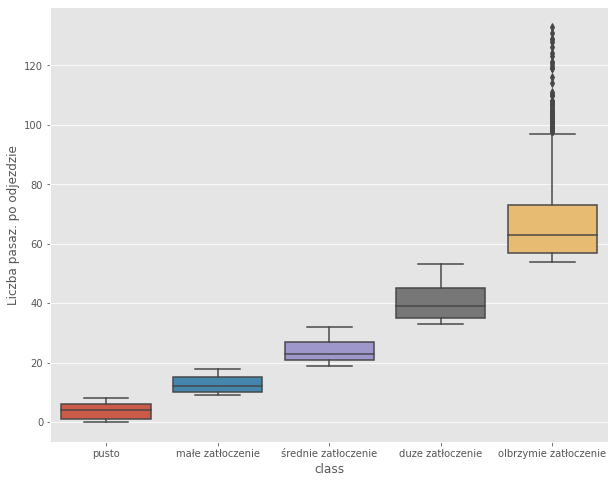

In [21]:
plt.figure(figsize=(10, 8))
ax = sns.boxplot(
    x='class',
    order=crowding,
    y='Liczba pasaz. po odjezdzie',
    data=df
)

In [122]:
def create_heatmap(df, corr):
    

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
dfheatmap = df['Liczba pasaz. po odjezdzie']

In [125]:
corr = df.corr()
corr

Numer taborowy  Numer przystanku  \
Numer taborowy                     1.000000         -0.002003   
Numer przystanku                  -0.002003          1.000000   
Liczba pasaz. przed                0.320958         -0.030895   
Liczba wysiadających pasaz.        0.124254          0.013882   
Liczba wsiadajacych pasaz.         0.123192          0.024542   
Liczba pasaz. po odjezdzie         0.321755         -0.028010   
Godzina odjazdu                   -0.002678         -0.000627   
Godzina odjazdu przedział         -0.002722         -0.000607   

                             Liczba pasaz. przed  Liczba wysiadających pasaz.  \
Numer taborowy                          0.320958                     0.124254   
Numer przystanku                       -0.030895                     0.013882   
Liczba pasaz. przed                     1.000000                     0.374577   
Liczba wysiadających pasaz.             0.374577                     1.000000   
Liczba wsiadajacych pasaz.              0.146987                     0.146362   
Liczba pasaz. po odjezdzie              0.944015                     0.160806   
Godzina odjazdu                        -0.049583                    -0.035205   
Godzina odjazdu przedział              -0.049621                    -0.035178   

                             Liczba wsiadajacych pasaz.  \
Numer taborowy                                 0.123192   
Numer przystanku                               0.024542   
Liczba pasaz. przed                            0.146987   
Liczba wysiadających pasaz.                    0.146362   
Liczba wsiadajacych pasaz.                     1.000000   
Liczba pasaz. po odjezdzie                     0.370362   
Godzina odjazdu                               -0.049363   
Godzina odjazdu przedział                     -0.049336   

                             Liczba pasaz. po odjezdzie  Godzina odjazdu  \
Numer taborowy                                 0.321755        -0.002678   
Numer przystanku                              -0.028010        -0.000627   
Liczba pasaz. przed                            0.944015        -0.049583   
Liczba wysiadających pasaz.                    0.160806        -0.035205   
Liczba wsiadajacych pasaz.                     0.370362        -0.049363   
Liczba pasaz. po odjezdzie                     1.000000        -0.053566   
Godzina odjazdu                               -0.053566         1.000000   
Godzina odjazdu przedział                     -0.053604         0.999908   

                             Godzina odjazdu przedział  
Numer taborowy                               -0.002722  
Numer przystanku                             -0.000607  
Liczba pasaz. przed                          -0.049621  
Liczba wysiadających pasaz.                  -0.035178  
Liczba wsiadajacych pasaz.                   -0.049336  
Liczba pasaz. po odjezdzie                   -0.053604  
Godzina odjazdu                               0.999908  
Godzina odjazdu przedział                     1.000000

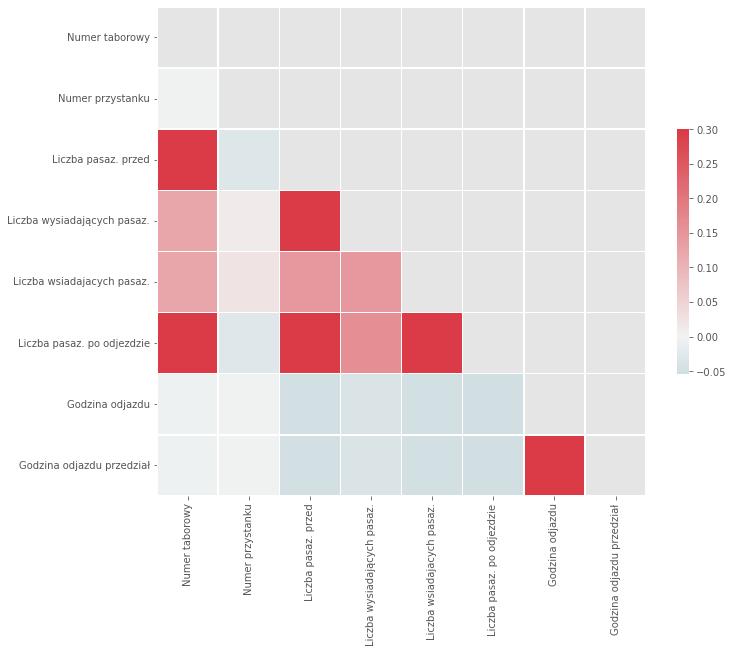

In [123]:
create_heatmap(df,corr)

# 7. SVM


In [67]:
from sklearn import svm
import seaborn as sns

In [68]:
dat = df[["Liczba pasaz. po odjezdzie", "Godzina odjazdu"]]

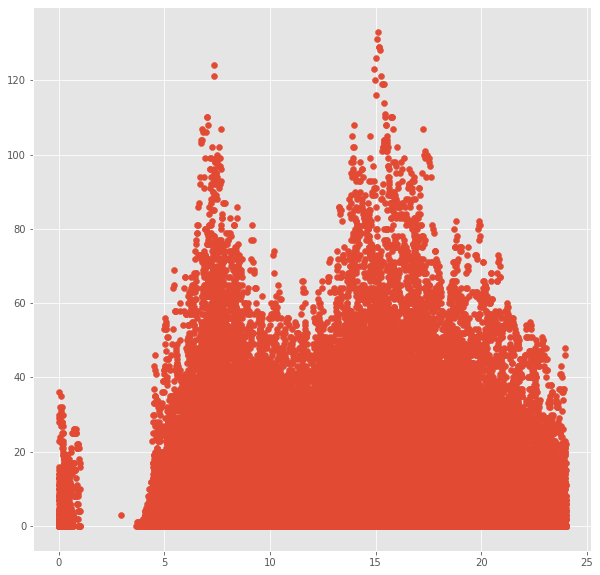

In [69]:
plt.figure(figsize=(10, 10))
plt.scatter(x = dat["Godzina odjazdu"], y = dat['Liczba pasaz. po odjezdzie'])
plt.show()

In [70]:
def show_me_outliers(data, nu, kernel, gamma):
    X = data
    w = len(nu)*len(gamma)*len(kernel)
    ins_outs = np.zeros((w, 2))
    k=0
    for i in range(len(nu)):
        for j in range(len(kernel)):
            for z in range(len(gamma)):
                clf2 = svm.OneClassSVM(nu = nu[i], gamma = gamma[z], kernel = kernel[j])
                #clf.fit(X, y)
                #1 for inliers, -1 for outliers
                # print(X)
                fit_predict = clf2.fit_predict(X)

                data['nu='+str(nu[i])+', gamma='+str(gamma[z])+', ' + str(kernel[j])] = pd.DataFrame(fit_predict)
                hue_col = str('nu='+str(nu[i])+', gamma='+str(gamma[z])+', ' + str(kernel[j]))
                plt.figure(hue_col, figsize = (10,10))
                sns.scatterplot(data = data, x = 'Godzina odjazdu', y = 'Liczba pasaz. po odjezdzie' , hue = hue_col)

                X = X.fillna(0)
                print(X)
                fit_predict = clf2.fit_predict(X)
                # fit_predict = pd.DataFrame(fit_predict).fillna(0)

                stats = np.unique(fit_predict, return_counts=True)
                print('stats', stats)
                print('stats[1][0]',stats[1][0])
                ins_outs[k,0] = stats[1][0]
                print('stats[1][1]',stats[1][1])
                ins_outs[k,1] = stats[1][1]
                
                k+=1

    ins_outs = pd.DataFrame(ins_outs, columns = stats[0], index = data.columns.values[-w:]).astype(int)         
    return data, ins_outs

C:\Users\Patryk\AppData\Local\Temp/ipykernel_18820/457044218.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['nu='+str(nu[i])+', gamma='+str(gamma[z])+', ' + str(kernel[j])] = pd.DataFrame(fit_predict)


        Liczba pasaz. po odjezdzie  Godzina odjazdu  nu=0.1, gamma=0.1, linear
0                                1         5.183333                       -1.0
1                                1         5.183333                       -1.0
2                                3         5.200000                       -1.0
3                                3         5.216667                       -1.0
4                                3         5.233333                       -1.0
...                            ...              ...                        ...
177541                          13        17.016667                        0.0
177542                           5        17.166667                        0.0
177543                           2        17.183333                        0.0
177544                           1        17.200000                        0.0
177545                           0        17.216667                        0.0

[167342 rows x 3 columns]
stats (array([-1,  1], dt

C:\Users\Patryk\AppData\Local\Temp/ipykernel_18820/457044218.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['nu='+str(nu[i])+', gamma='+str(gamma[z])+', ' + str(kernel[j])] = pd.DataFrame(fit_predict)


        Liczba pasaz. po odjezdzie  Godzina odjazdu  nu=0.1, gamma=0.1, linear
0                                1         5.183333                       -1.0
1                                1         5.183333                       -1.0
2                                3         5.200000                       -1.0
3                                3         5.216667                       -1.0
4                                3         5.233333                       -1.0
...                            ...              ...                        ...
177541                          13        17.016667                        0.0
177542                           5        17.166667                        0.0
177543                           2        17.183333                        0.0
177544                           1        17.200000                        0.0
177545                           0        17.216667                        0.0

[167342 rows x 3 columns]
stats (array([-1,  1], dt

C:\Users\Patryk\AppData\Local\Temp/ipykernel_18820/457044218.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['nu='+str(nu[i])+', gamma='+str(gamma[z])+', ' + str(kernel[j])] = pd.DataFrame(fit_predict)


        Liczba pasaz. po odjezdzie  Godzina odjazdu  nu=0.1, gamma=0.1, linear
0                                1         5.183333                       -1.0
1                                1         5.183333                       -1.0
2                                3         5.200000                       -1.0
3                                3         5.216667                       -1.0
4                                3         5.233333                       -1.0
...                            ...              ...                        ...
177541                          13        17.016667                        0.0
177542                           5        17.166667                        0.0
177543                           2        17.183333                        0.0
177544                           1        17.200000                        0.0
177545                           0        17.216667                        0.0

[167342 rows x 3 columns]
stats (array([-1,  1], dt

C:\Users\Patryk\AppData\Local\Temp/ipykernel_18820/457044218.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['nu='+str(nu[i])+', gamma='+str(gamma[z])+', ' + str(kernel[j])] = pd.DataFrame(fit_predict)


        Liczba pasaz. po odjezdzie  Godzina odjazdu  nu=0.1, gamma=0.1, linear
0                                1         5.183333                       -1.0
1                                1         5.183333                       -1.0
2                                3         5.200000                       -1.0
3                                3         5.216667                       -1.0
4                                3         5.233333                       -1.0
...                            ...              ...                        ...
177541                          13        17.016667                        0.0
177542                           5        17.166667                        0.0
177543                           2        17.183333                        0.0
177544                           1        17.200000                        0.0
177545                           0        17.216667                        0.0

[167342 rows x 3 columns]
stats (array([-1,  1], dt

C:\Users\Patryk\AppData\Local\Temp/ipykernel_18820/457044218.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['nu='+str(nu[i])+', gamma='+str(gamma[z])+', ' + str(kernel[j])] = pd.DataFrame(fit_predict)


        Liczba pasaz. po odjezdzie  Godzina odjazdu  nu=0.1, gamma=0.1, linear
0                                1         5.183333                       -1.0
1                                1         5.183333                       -1.0
2                                3         5.200000                       -1.0
3                                3         5.216667                       -1.0
4                                3         5.233333                       -1.0
...                            ...              ...                        ...
177541                          13        17.016667                        0.0
177542                           5        17.166667                        0.0
177543                           2        17.183333                        0.0
177544                           1        17.200000                        0.0
177545                           0        17.216667                        0.0

[167342 rows x 3 columns]
stats (array([-1,  1], dt

C:\Users\Patryk\AppData\Local\Temp/ipykernel_18820/457044218.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['nu='+str(nu[i])+', gamma='+str(gamma[z])+', ' + str(kernel[j])] = pd.DataFrame(fit_predict)


        Liczba pasaz. po odjezdzie  Godzina odjazdu  nu=0.1, gamma=0.1, linear
0                                1         5.183333                       -1.0
1                                1         5.183333                       -1.0
2                                3         5.200000                       -1.0
3                                3         5.216667                       -1.0
4                                3         5.233333                       -1.0
...                            ...              ...                        ...
177541                          13        17.016667                        0.0
177542                           5        17.166667                        0.0
177543                           2        17.183333                        0.0
177544                           1        17.200000                        0.0
177545                           0        17.216667                        0.0

[167342 rows x 3 columns]
stats (array([-1,  1], dt

C:\Users\Patryk\AppData\Local\Temp/ipykernel_18820/457044218.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['nu='+str(nu[i])+', gamma='+str(gamma[z])+', ' + str(kernel[j])] = pd.DataFrame(fit_predict)


        Liczba pasaz. po odjezdzie  Godzina odjazdu  nu=0.1, gamma=0.1, linear
0                                1         5.183333                       -1.0
1                                1         5.183333                       -1.0
2                                3         5.200000                       -1.0
3                                3         5.216667                       -1.0
4                                3         5.233333                       -1.0
...                            ...              ...                        ...
177541                          13        17.016667                        0.0
177542                           5        17.166667                        0.0
177543                           2        17.183333                        0.0
177544                           1        17.200000                        0.0
177545                           0        17.216667                        0.0

[167342 rows x 3 columns]
stats (array([-1,  1], dt

C:\Users\Patryk\AppData\Local\Temp/ipykernel_18820/457044218.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['nu='+str(nu[i])+', gamma='+str(gamma[z])+', ' + str(kernel[j])] = pd.DataFrame(fit_predict)


        Liczba pasaz. po odjezdzie  Godzina odjazdu  nu=0.1, gamma=0.1, linear
0                                1         5.183333                       -1.0
1                                1         5.183333                       -1.0
2                                3         5.200000                       -1.0
3                                3         5.216667                       -1.0
4                                3         5.233333                       -1.0
...                            ...              ...                        ...
177541                          13        17.016667                        0.0
177542                           5        17.166667                        0.0
177543                           2        17.183333                        0.0
177544                           1        17.200000                        0.0
177545                           0        17.216667                        0.0

[167342 rows x 3 columns]
stats (array([-1,  1], dt

C:\Users\Patryk\AppData\Local\Temp/ipykernel_18820/457044218.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['nu='+str(nu[i])+', gamma='+str(gamma[z])+', ' + str(kernel[j])] = pd.DataFrame(fit_predict)


        Liczba pasaz. po odjezdzie  Godzina odjazdu  nu=0.1, gamma=0.1, linear
0                                1         5.183333                       -1.0
1                                1         5.183333                       -1.0
2                                3         5.200000                       -1.0
3                                3         5.216667                       -1.0
4                                3         5.233333                       -1.0
...                            ...              ...                        ...
177541                          13        17.016667                        0.0
177542                           5        17.166667                        0.0
177543                           2        17.183333                        0.0
177544                           1        17.200000                        0.0
177545                           0        17.216667                        0.0

[167342 rows x 3 columns]
stats (array([-1,  1], dt

C:\Users\Patryk\AppData\Local\Temp/ipykernel_18820/457044218.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['nu='+str(nu[i])+', gamma='+str(gamma[z])+', ' + str(kernel[j])] = pd.DataFrame(fit_predict)


        Liczba pasaz. po odjezdzie  Godzina odjazdu  nu=0.1, gamma=0.1, linear
0                                1         5.183333                       -1.0
1                                1         5.183333                       -1.0
2                                3         5.200000                       -1.0
3                                3         5.216667                       -1.0
4                                3         5.233333                       -1.0
...                            ...              ...                        ...
177541                          13        17.016667                        0.0
177542                           5        17.166667                        0.0
177543                           2        17.183333                        0.0
177544                           1        17.200000                        0.0
177545                           0        17.216667                        0.0

[167342 rows x 3 columns]
stats (array([-1,  1], dt

C:\Users\Patryk\AppData\Local\Temp/ipykernel_18820/457044218.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['nu='+str(nu[i])+', gamma='+str(gamma[z])+', ' + str(kernel[j])] = pd.DataFrame(fit_predict)


        Liczba pasaz. po odjezdzie  Godzina odjazdu  nu=0.1, gamma=0.1, linear
0                                1         5.183333                       -1.0
1                                1         5.183333                       -1.0
2                                3         5.200000                       -1.0
3                                3         5.216667                       -1.0
4                                3         5.233333                       -1.0
...                            ...              ...                        ...
177541                          13        17.016667                        0.0
177542                           5        17.166667                        0.0
177543                           2        17.183333                        0.0
177544                           1        17.200000                        0.0
177545                           0        17.216667                        0.0

[167342 rows x 3 columns]
stats (array([-1,  1], dt

C:\Users\Patryk\AppData\Local\Temp/ipykernel_18820/457044218.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['nu='+str(nu[i])+', gamma='+str(gamma[z])+', ' + str(kernel[j])] = pd.DataFrame(fit_predict)


        Liczba pasaz. po odjezdzie  Godzina odjazdu  nu=0.1, gamma=0.1, linear
0                                1         5.183333                       -1.0
1                                1         5.183333                       -1.0
2                                3         5.200000                       -1.0
3                                3         5.216667                       -1.0
4                                3         5.233333                       -1.0
...                            ...              ...                        ...
177541                          13        17.016667                        0.0
177542                           5        17.166667                        0.0
177543                           2        17.183333                        0.0
177544                           1        17.200000                        0.0
177545                           0        17.216667                        0.0

[167342 rows x 3 columns]
stats (array([-1,  1], dt

-1       1
nu=0.1, gamma=0.1, linear  16737  150605
nu=0.1, gamma=0.5, linear  16737  150605
nu=0.1, gamma=0.1, poly    16736  150606
nu=0.1, gamma=0.5, poly    16736  150606
nu=0.1, gamma=0.1, rbf     16949  150393
nu=0.1, gamma=0.5, rbf     38734  128608
nu=0.5, gamma=0.1, linear  83675   83667
nu=0.5, gamma=0.5, linear  83675   83667
nu=0.5, gamma=0.1, poly    83672   83670
nu=0.5, gamma=0.5, poly    83667   83675
nu=0.5, gamma=0.1, rbf     83703   83639
nu=0.5, gamma=0.5, rbf     86103   81239

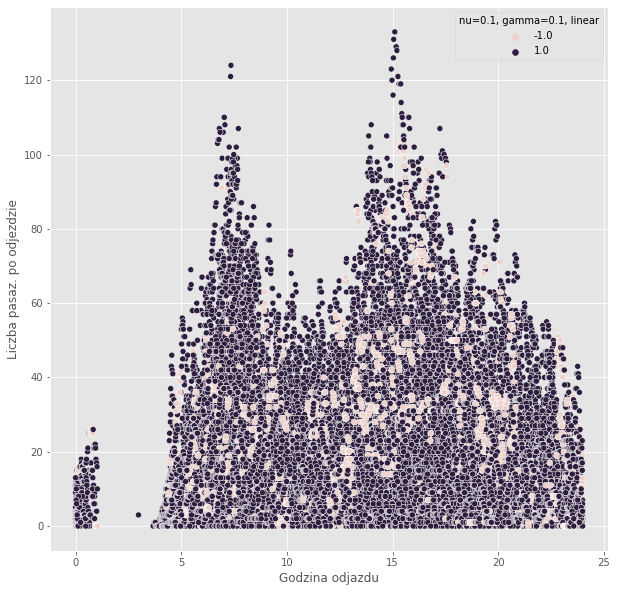

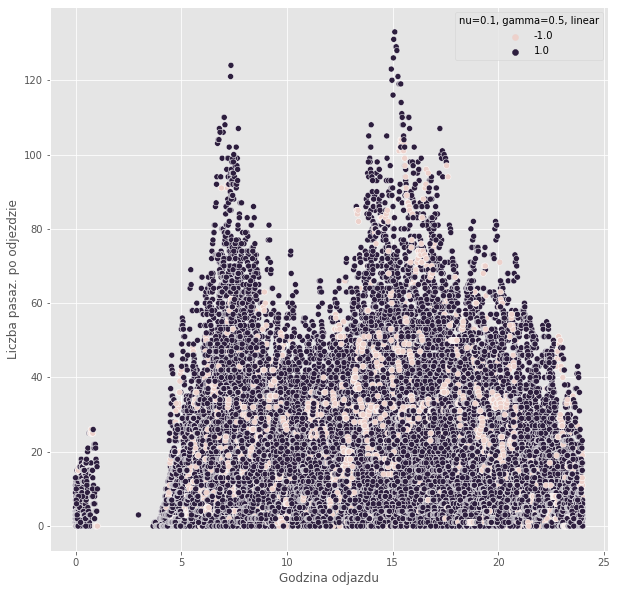

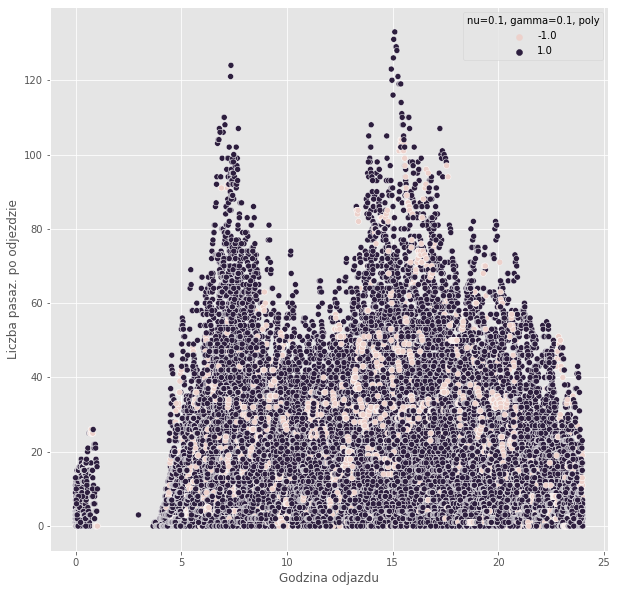

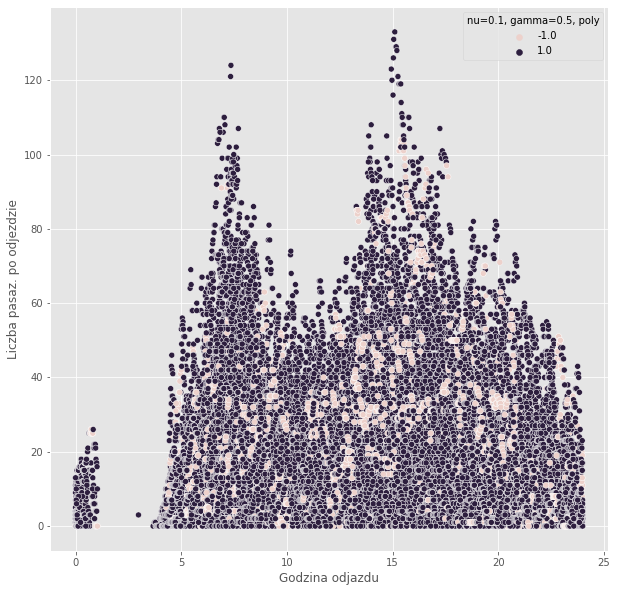

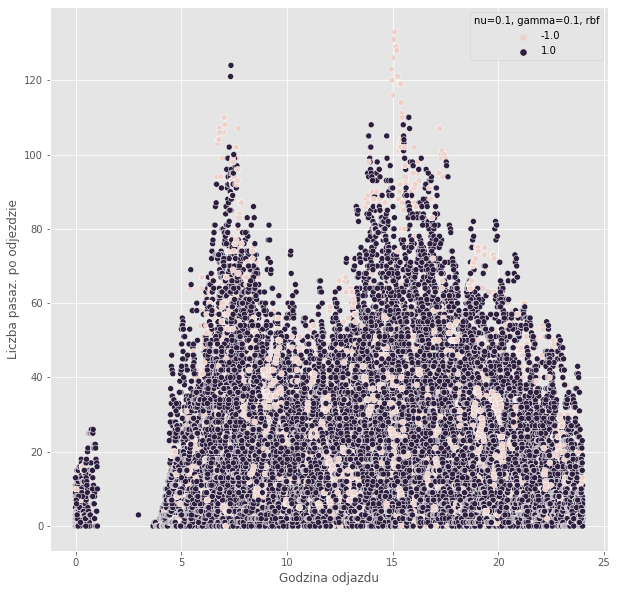

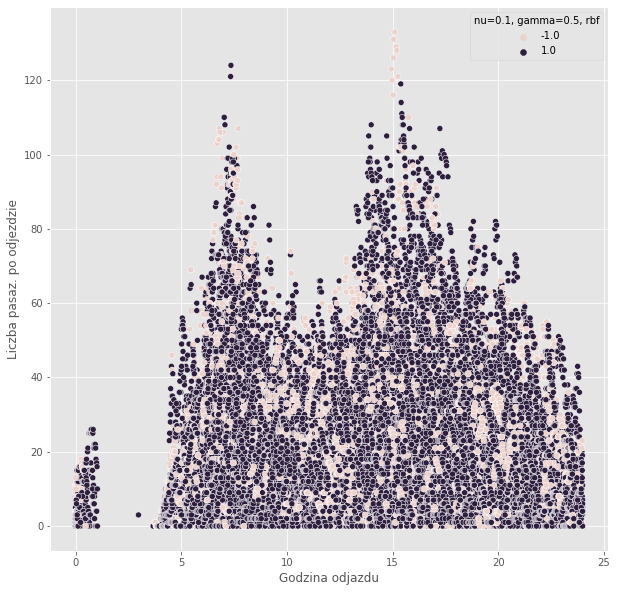

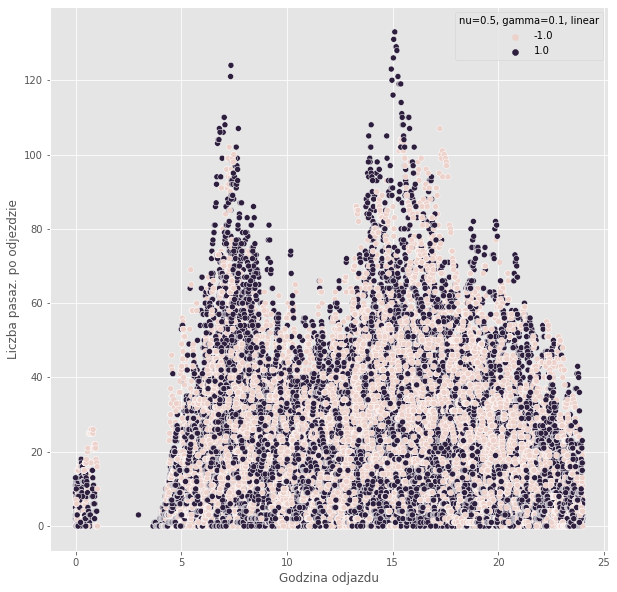

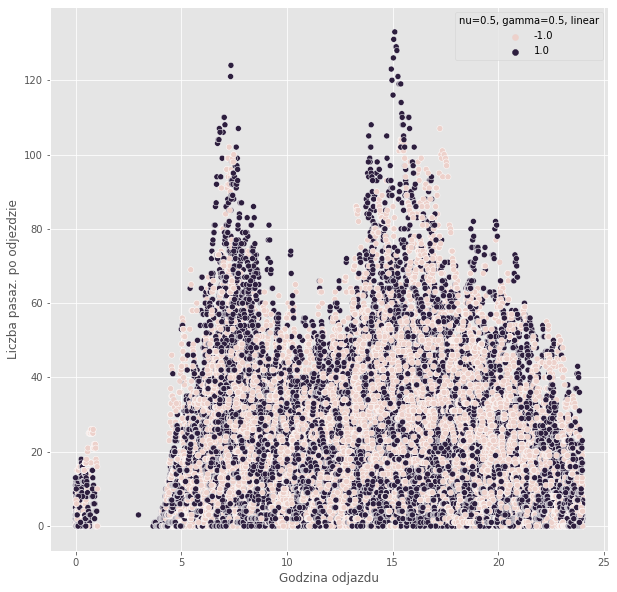

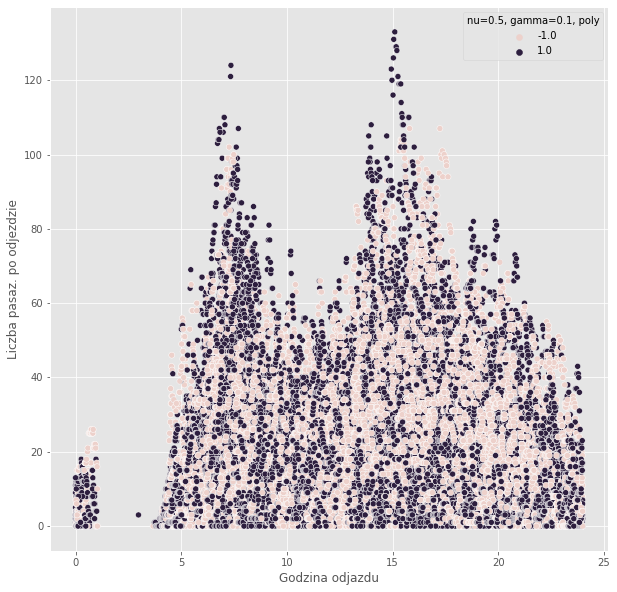

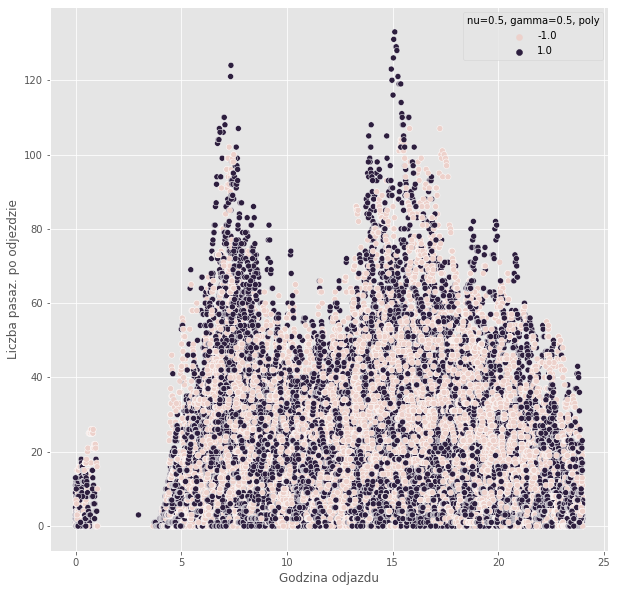

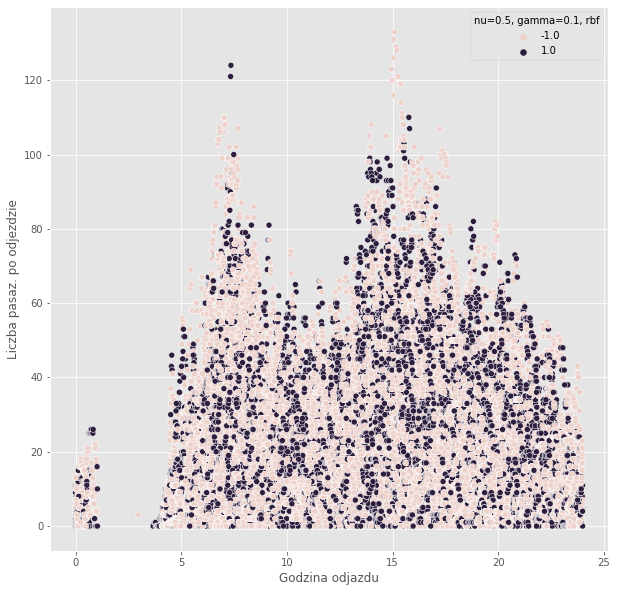

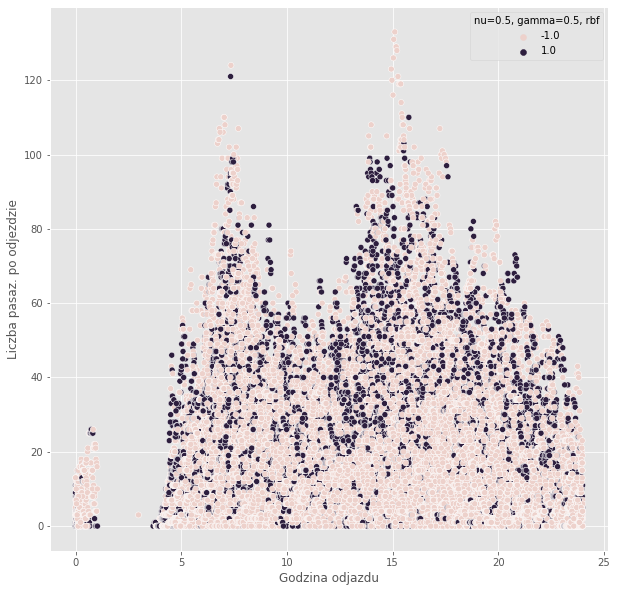

In [71]:
nu = [0.1, 0.5]
gamma = [0.1, 0.5]
kernel = ['linear', 'poly', 'rbf']
#‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’, default = 'rbf'
df2 = dat
df2, ins_out = show_me_outliers(data = df2, nu = nu, kernel = kernel, gamma = gamma)
ins_out

In [72]:
ins_out

-1       1
nu=0.1, gamma=0.1, linear  16737  150605
nu=0.1, gamma=0.5, linear  16737  150605
nu=0.1, gamma=0.1, poly    16736  150606
nu=0.1, gamma=0.5, poly    16736  150606
nu=0.1, gamma=0.1, rbf     16949  150393
nu=0.1, gamma=0.5, rbf     38734  128608
nu=0.5, gamma=0.1, linear  83675   83667
nu=0.5, gamma=0.5, linear  83675   83667
nu=0.5, gamma=0.1, poly    83672   83670
nu=0.5, gamma=0.5, poly    83667   83675
nu=0.5, gamma=0.1, rbf     83703   83639
nu=0.5, gamma=0.5, rbf     86103   81239

# 7.1. SVM cd

In [5]:
# importing necessary libraries
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
# training a linear SVM classifier
from sklearn.svm import SVC

In [2]:
# loading the iris dataset
iris = datasets.load_iris()
 
# X -> features, y -> label
X = iris.data
y = iris.target
 
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [3]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [7]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
svm_predictions = svm_model_linear.predict(X_test)
 
# model accuracy for X_test 
accuracy = svm_model_linear.score(X_test, y_test)
 
# creating a confusion matrix
cm = confusion_matrix(y_test, svm_predictions)
cm

array([[13,  0,  0],
       [ 0, 15,  1],
       [ 0,  0,  9]], dtype=int64)

# 8. Drzewa

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt

In [41]:
def create_tree(features, label, __df, max_depth = 3):
    X_train = __df[features]
    y_train = __df[label]
    
    clf = DecisionTreeClassifier(
        random_state = RANDOM_SEED,
        max_depth = max_depth,
        criterion = 'gini'
    )
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    
    feature_importances = {
        'Feature': features,
        'Importance': clf.feature_importances_
    }
    
    feature_importances_df = pd.DataFrame.from_dict(feature_importances)
    print(feature_importances_df)
    
    cr = classification_report(
        y_train, 
        y_pred, 
        target_names=clf.classes_,
        zero_division=0
    )
    print(cr)
    
    cm = confusion_matrix(
        y_train, 
        y_pred, 
        labels=clf.classes_
    )
    
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=clf.classes_
    )
    disp.plot()
    
    plt.figure(figsize=(80, 60))
    plot_tree(
        clf, 
        filled = True,
        rounded = True,
        label = 'all',
        class_names = clf.classes_
    )
    return clf

In [56]:
df_tree = df_no_type.drop(columns=['Wariant linii','Nazwa przystanku', 'Numer przystanku', 'Rzeczywisty czas odjazdu', 'Rozkładowy czas odjazdu', 'Kurs', 'Oznaczenie brygady'], inplace= False)
df_tree.sample(5)

Nr linii  Numer taborowy  Liczba pasaz. przed  \
100101      209            9233                    1   
122709      256            9359                   11   
49510       159            9531                    8   
14861       123            9417                   47   
159541      739            9352                   15   

        Liczba wysiadających pasaz.  Liczba wsiadajacych pasaz.  \
100101                            0                           0   
122709                            0                           1   
49510                             0                           1   
14861                             1                           2   
159541                            2                           0   

        Liczba pasaz. po odjezdzie  Godzina odjazdu  \
100101                           1        22.383333   
122709                          12        10.833333   
49510                            9         7.116667   
14861                           48        19.433333   
159541                          13        23.550000   

        Godzina odjazdu przedział             class  
100101                         89             pusto  
122709                         43  małe zatłoczenie  
49510                          28  małe zatłoczenie  
14861                          77  duze zatłoczenie  
159541                         94  małe zatłoczenie

                       Feature  Importance
0                     Nr linii         0.0
1               Numer taborowy         0.0
2          Liczba pasaz. przed         0.0
3  Liczba wysiadających pasaz.         0.0
4   Liczba wsiadajacych pasaz.         0.0
5   Liczba pasaz. po odjezdzie         1.0
6              Godzina odjazdu         0.0
7    Godzina odjazdu przedział         0.0
                       precision    recall  f1-score   support

     duze zatłoczenie       1.00      1.00      1.00      8248
     małe zatłoczenie       1.00      1.00      1.00     48870
olbrzymie zatłoczenie       1.00      1.00      1.00      2374
                pusto       1.00      1.00      1.00     77347
  średnie zatłoczenie       1.00      1.00      1.00     22888

             accuracy                           1.00    159727
            macro avg       1.00      1.00      1.00    159727
         weighted avg       1.00      1.00      1.00    159727



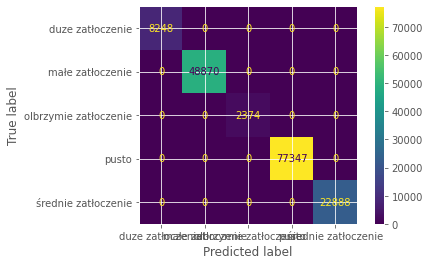

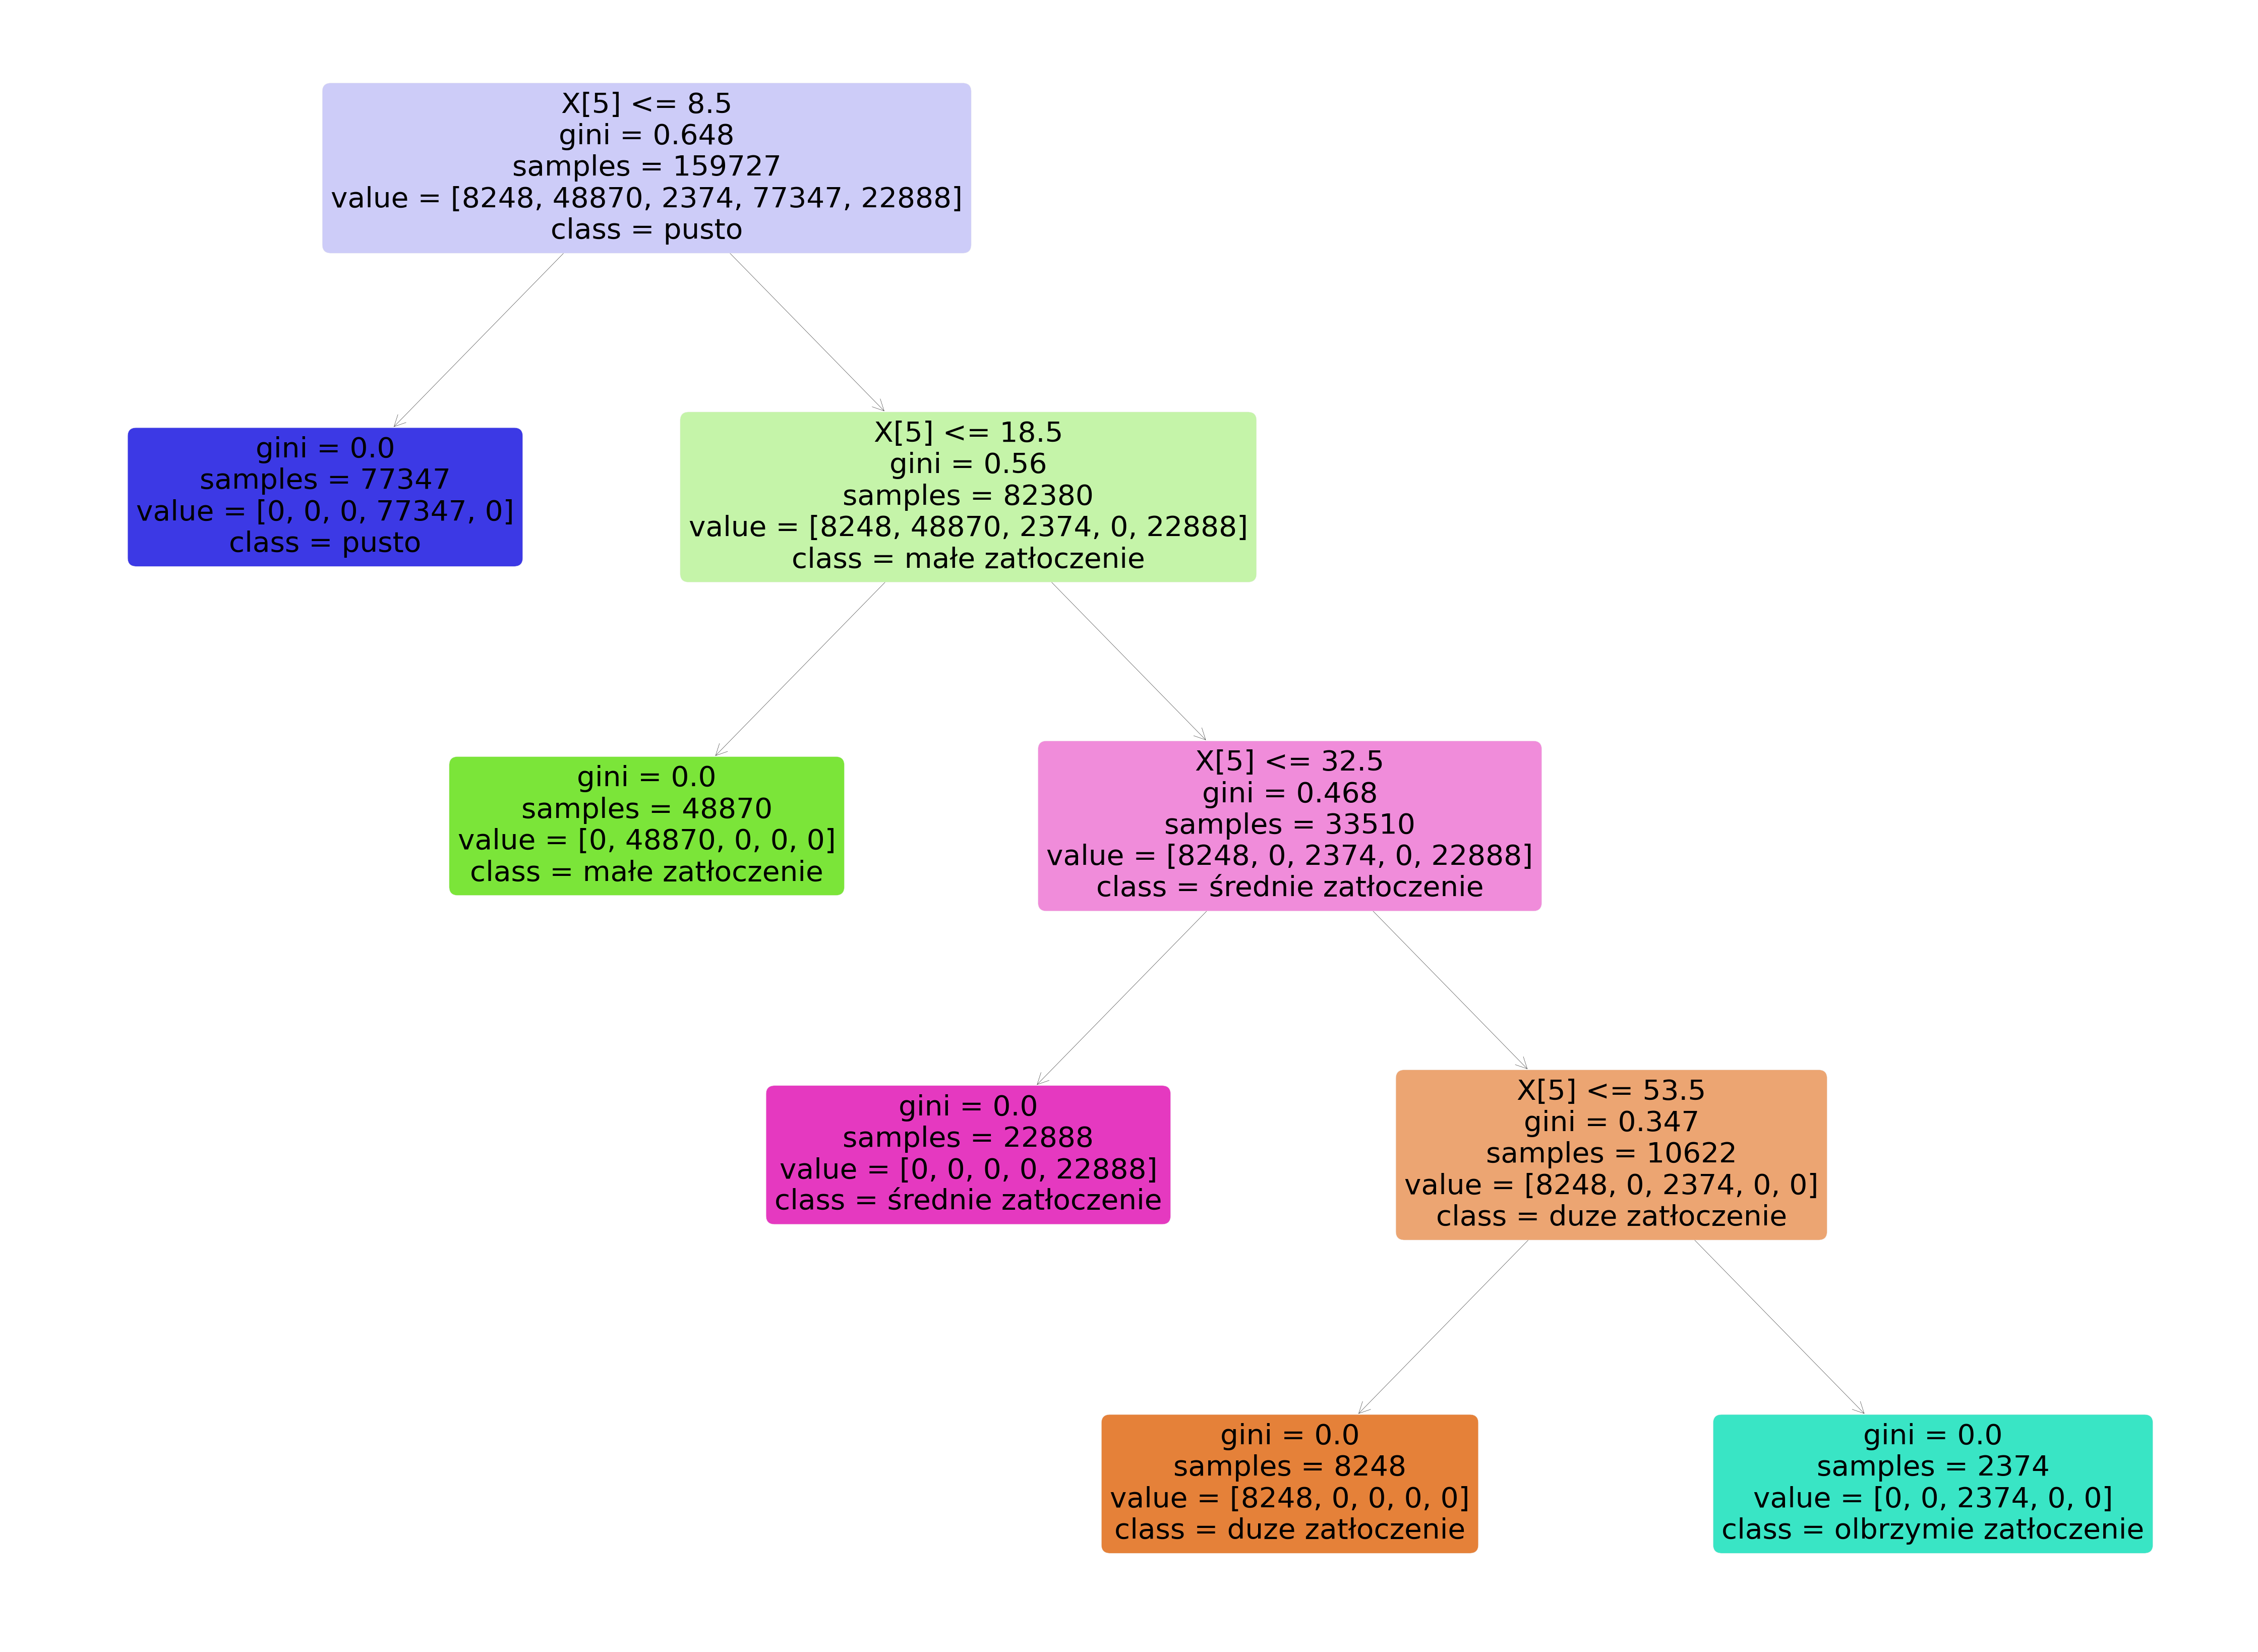

In [64]:
label = 'class'
features = df_tree.columns[:-1]

tree = create_tree(features, label, df_tree, max_depth=4)

# 9. PCA